In [1]:
# the key idea is that instead of doing L2 training we do sobolev training ! 

# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.17.2
#   kernelspec:
#     display_name: .venv
#     language: python
#     name: python3
# ---

In [2]:
from sciml.model.deeponet import DeepONet
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sciml.data.preprocessing.process_given_dataset import get_mu_xs_sol

tf.config.list_physical_devices('GPU')

2025-08-06 10:26:19.405069: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 10:26:19.415231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754490379.426161  264998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754490379.429311  264998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754490379.439907  264998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
d_p = 20
d_V = 20
epochs = 10

trying to enforce the boundary condition

In [4]:
class ConstrainedExternalModel(tf.keras.Model):
    def __init__(self, base_model, d_V):
        super().__init__()
        self.base_model = base_model
        self.d_V = d_V
    
    def call(self, x):
        """
        External model with boundary constraints: forces solution to be 0 at x=0 and x=1
        Uses basis functions that vanish at boundaries: x*(1-x), x^2*(1-x), etc.
        """
        # we get the base model output for learnable coefficients
        base_output = self.base_model(x)  # shape: (batch*n_points, d_V-1)
        
        # we extract x coordinates 
        x_coords = tf.squeeze(x, axis=-1)  # shape: (batch*n_points,)
        
        # we create basis functions that vanish at boundaries
        # First basis: x*(1-x) - vanishes at both x=0 and x=1
        basis_boundary = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        
        # we multiply all learned bases by x*(1-x) to ensure they vanish at boundaries
        x_factor = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        constrained_bases = base_output * x_factor
        
        # we concatenate: [x*(1-x), constrained_bases...]
        constrained_output = tf.concat([basis_boundary, constrained_bases], axis=1)
        
        return constrained_output

# we create the normal internal model (no constraints needed)
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu')
    # full d_V output
])

# we create the constrained external model
base_external = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(d_V-1, activation='elu')  # we reduce by 1 for the boundary basis
])

external_model = ConstrainedExternalModel(base_external, d_V)

I0000 00:00:1754490381.992946  264998 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
folder_path = "/home/janis/SCIML/summerschool/data/benchmarks/given/"
coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)

In [6]:
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs,"learning_rate":0.0005},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-06 10:26:22,755 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.0005 learning rate


In [7]:
mus, xs, sol = get_mu_xs_sol(folder_path,0.2)

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


In [8]:
print(mus.shape)
print(xs.shape)
print(sol.shape)

(2000, 100)
(2000, 100, 1)
(2000, 100)


mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 10:26:23.082119: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-06 10:26:23,568 - tensorflow - WARNING - Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
2025-08-06 10:26:26.747196: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 10:26:27,286 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:26:27,286 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.043648
2025-08-06 10:26:27,287 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.037834
Training progress:  10%|█         | 1/10 [00:04<00:37,  4.17s/it]2025-08-06 10:26:29.463399: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is abor

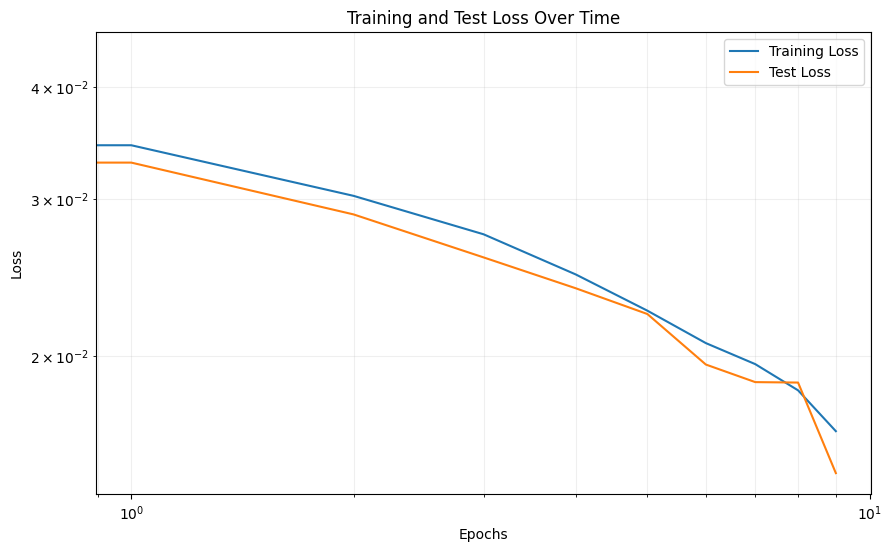

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


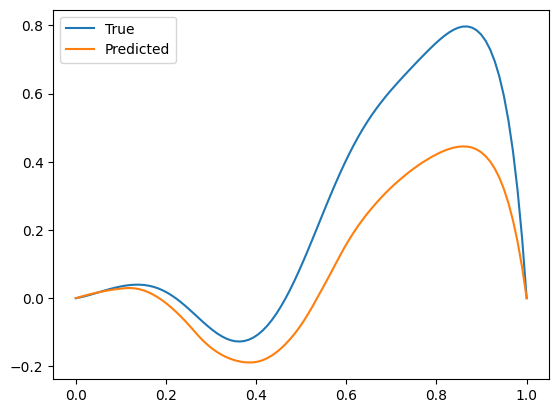

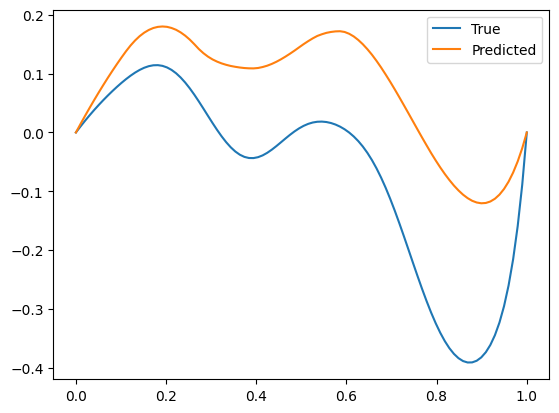

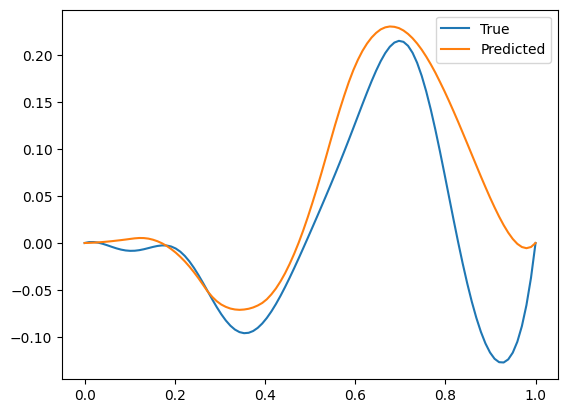

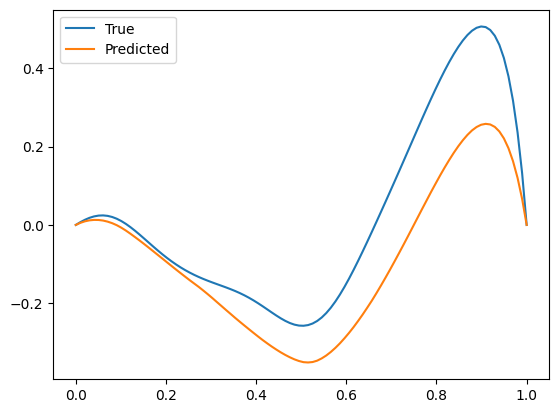

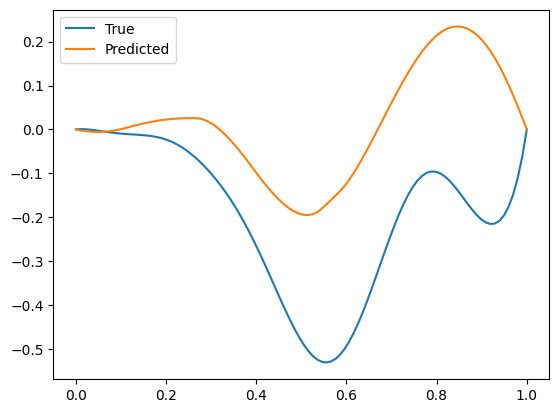

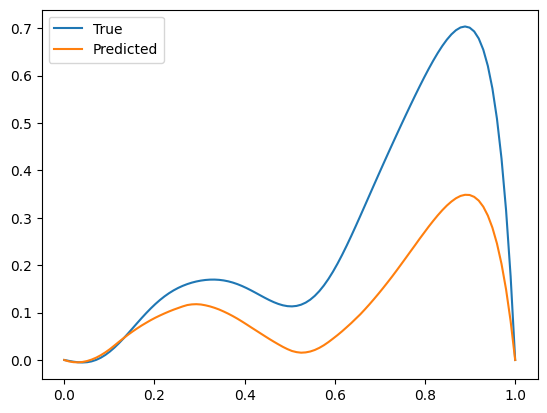

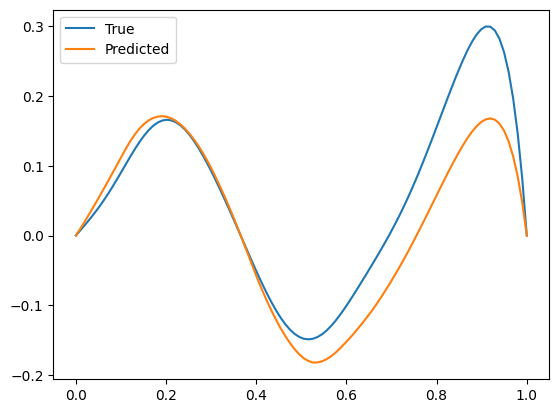

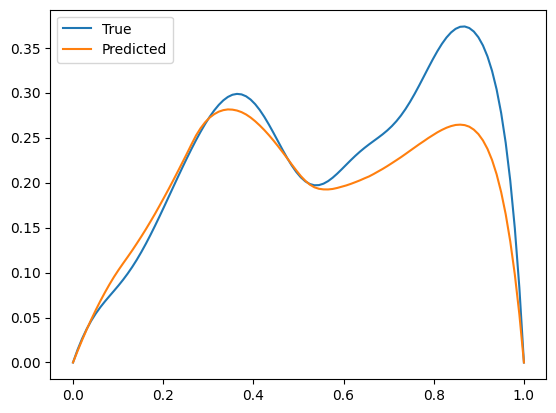

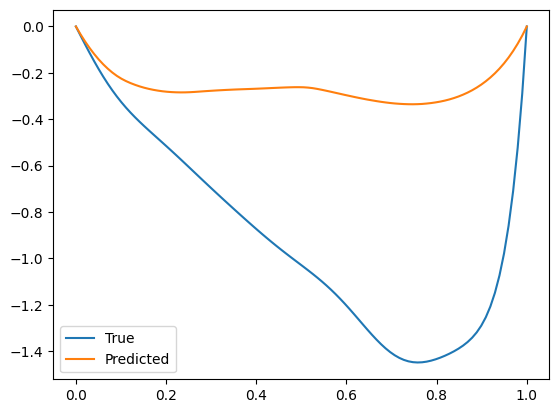

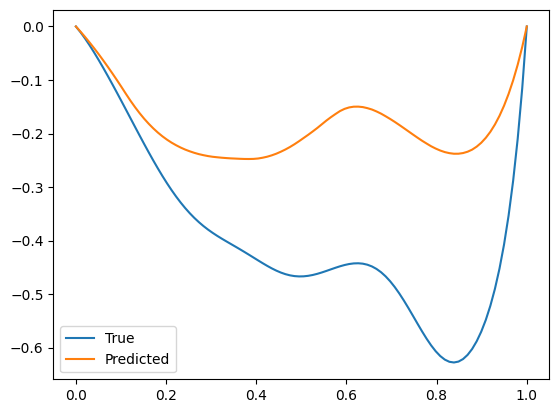

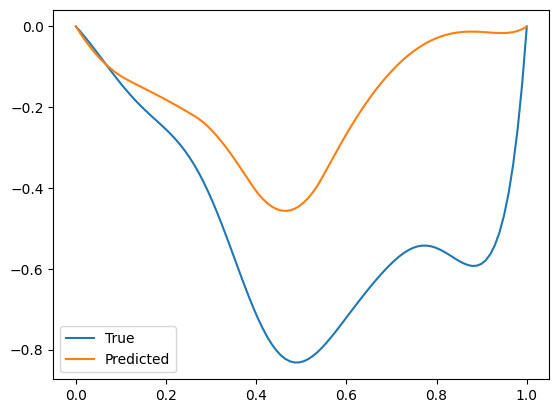

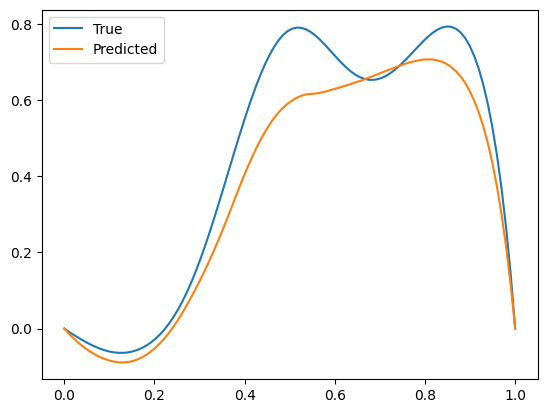

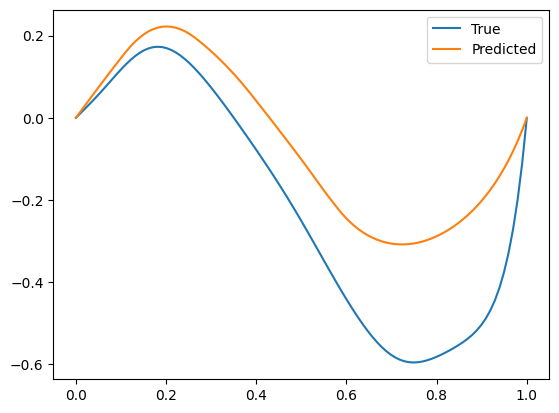

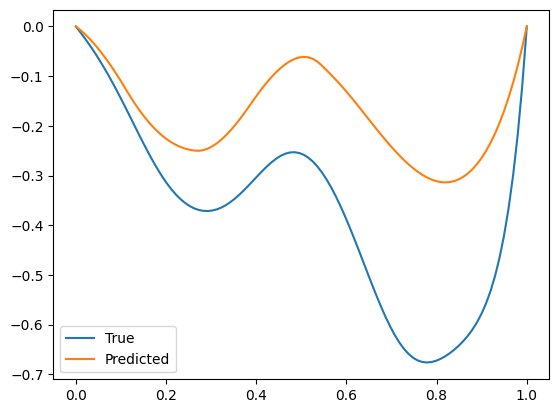

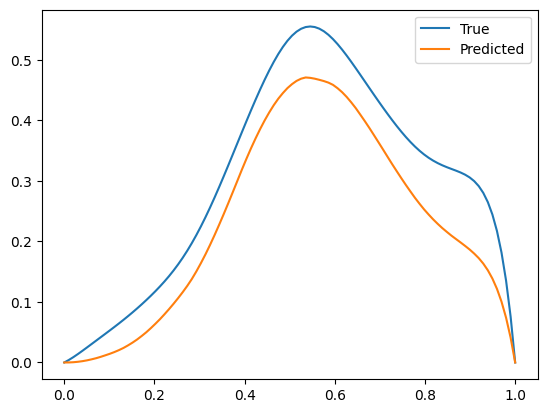

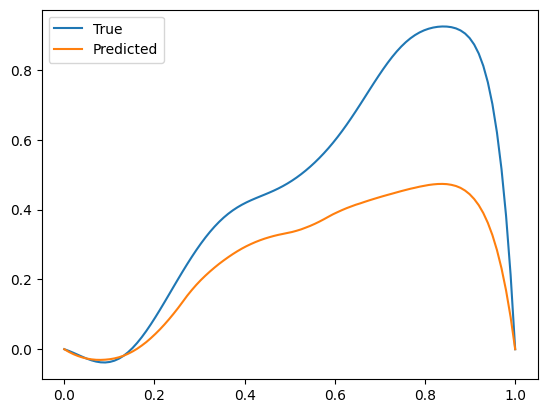

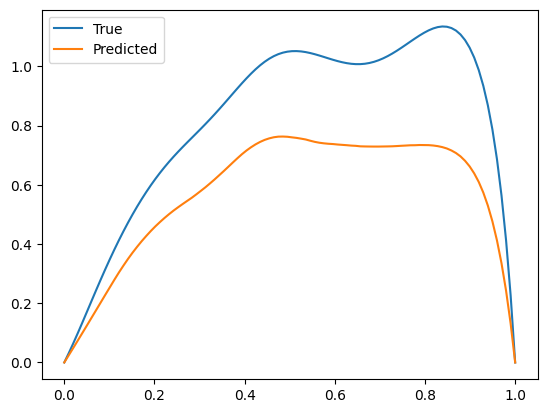

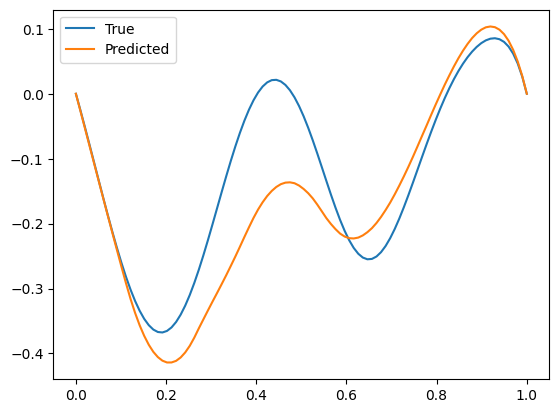

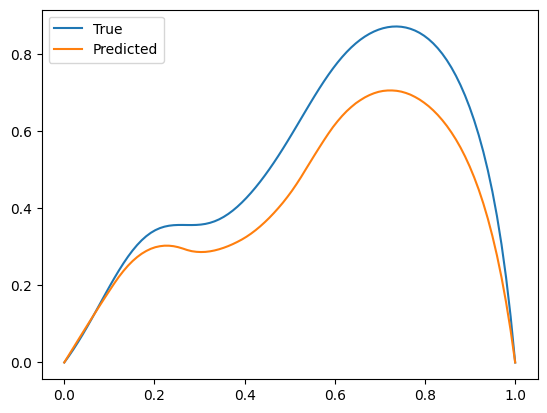

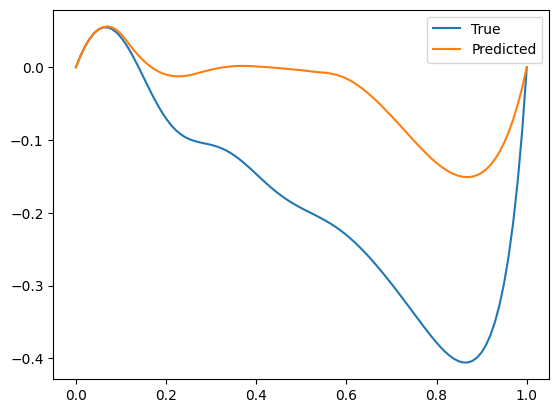

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:26:58,041 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:26:58,042 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.014228
2025-08-06 10:26:58,042 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011372
Training progress:  10%|█         | 1/10 [00:03<00:33,  3.68s/it]2025-08-06 10:27:01,491 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:27:01,492 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.009597
2025-08-06 10:27:01,493 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008468
Training progress:  20%|██        | 2/10 [00:07<00:28,  3.54s/it]2025-08-06 10:27:04,931 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:27:04,931 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008251
2025-08-06 10:27:04,932 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008282
Training progress:  30%|███       | 3/10 [00:10<00:24,  3.50s/i

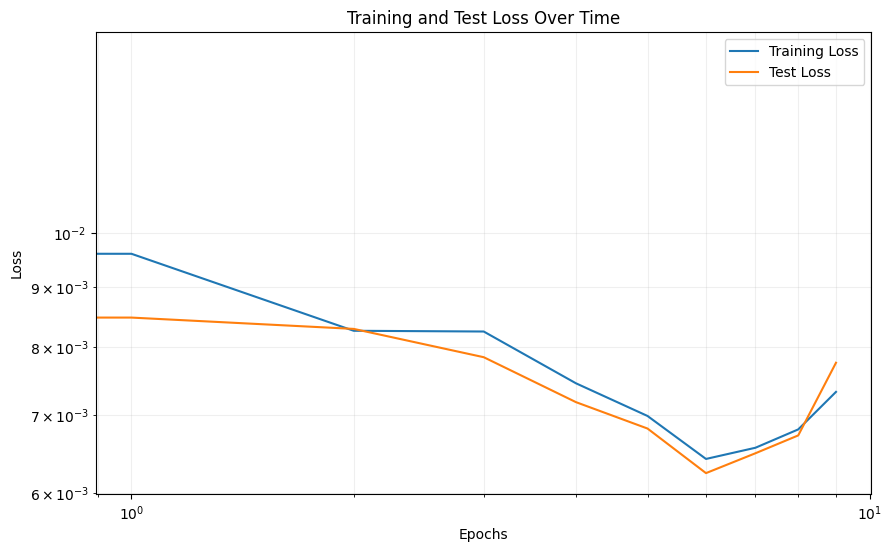

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


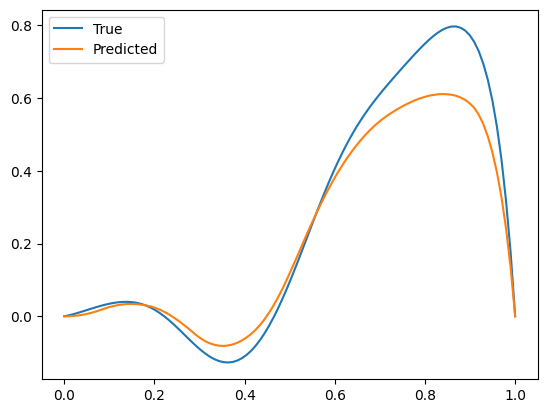

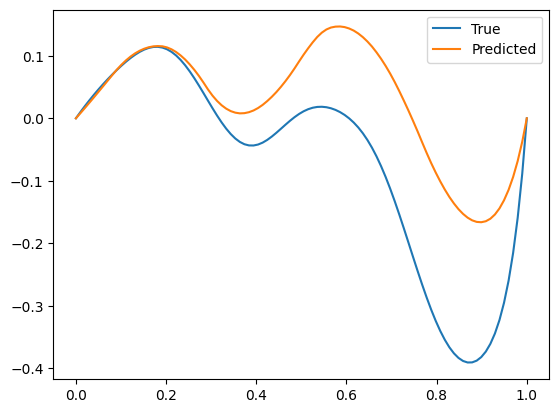

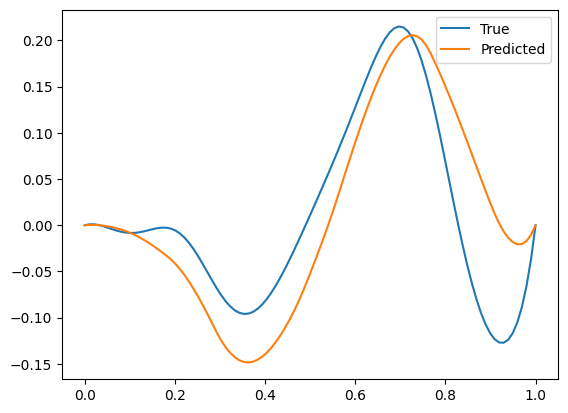

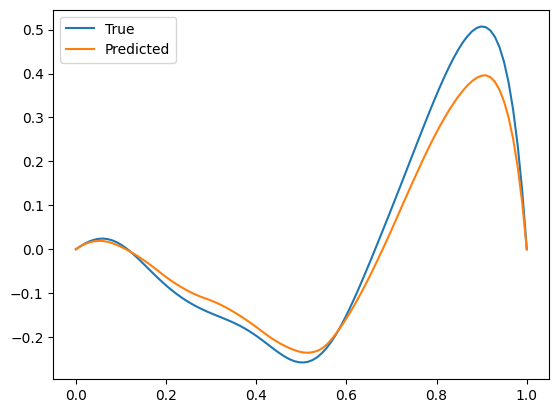

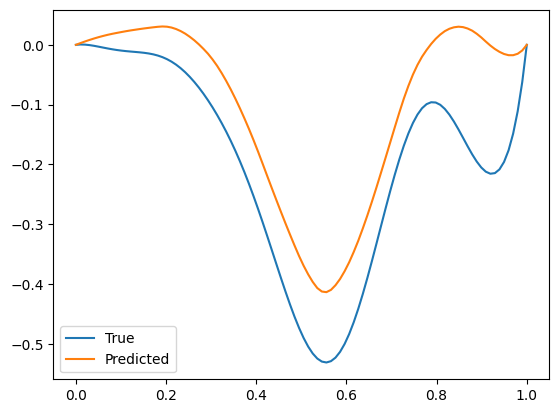

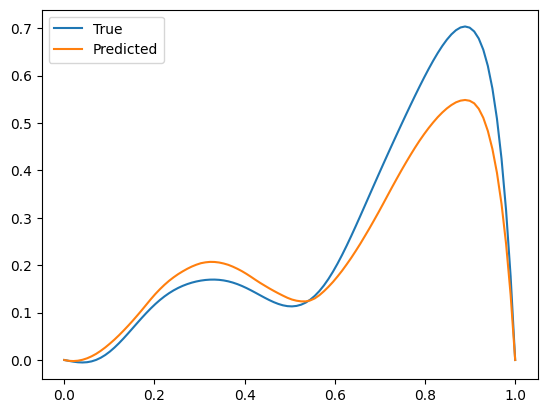

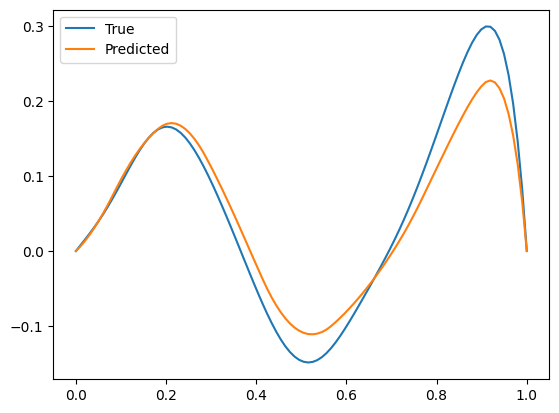

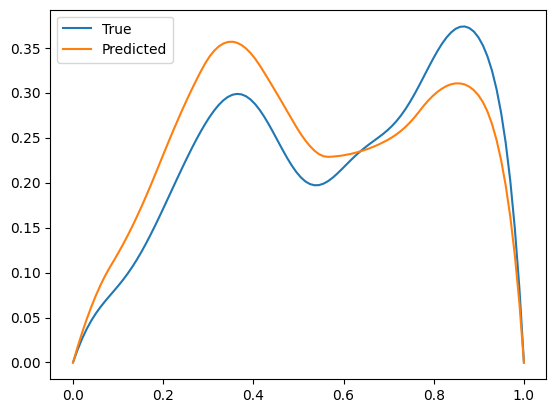

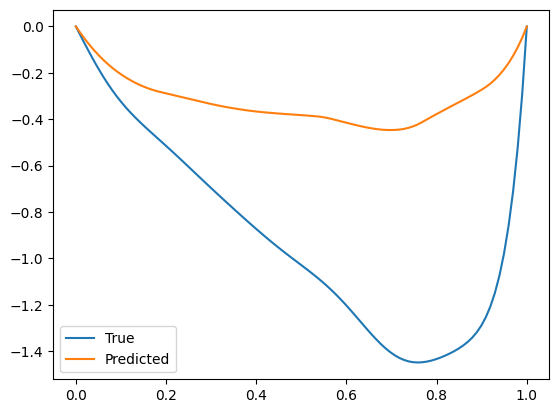

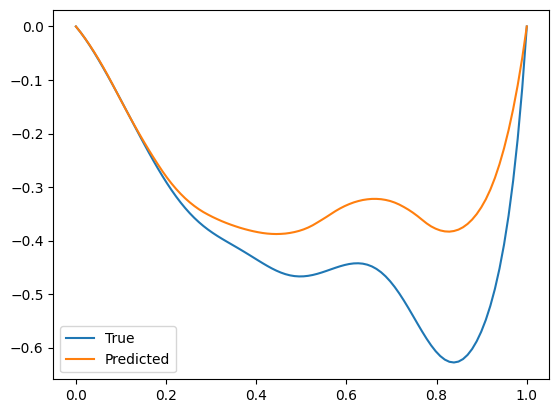

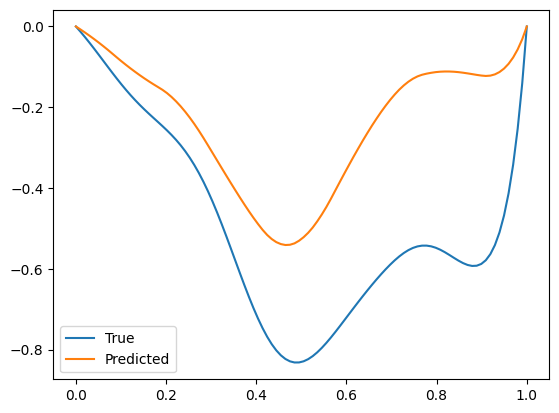

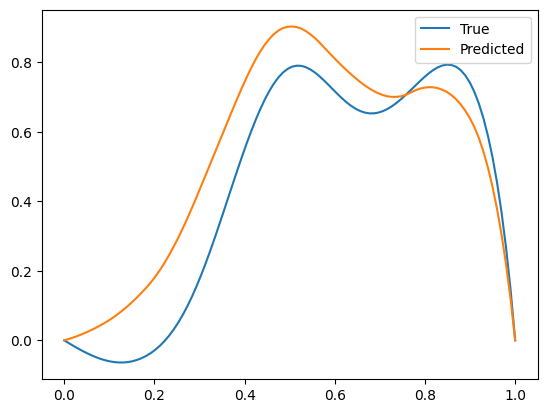

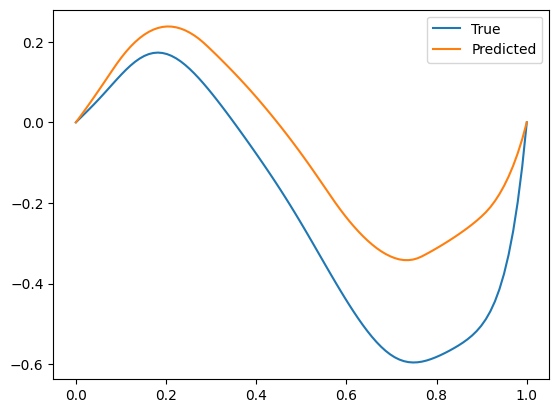

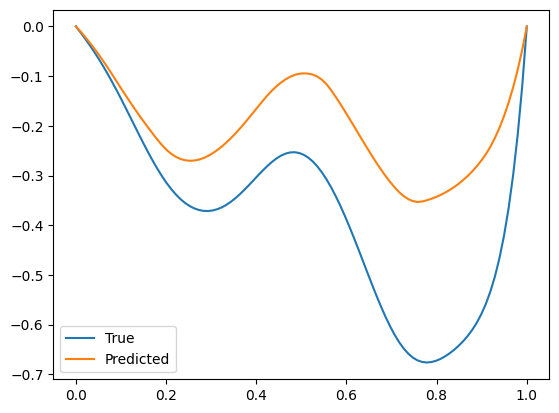

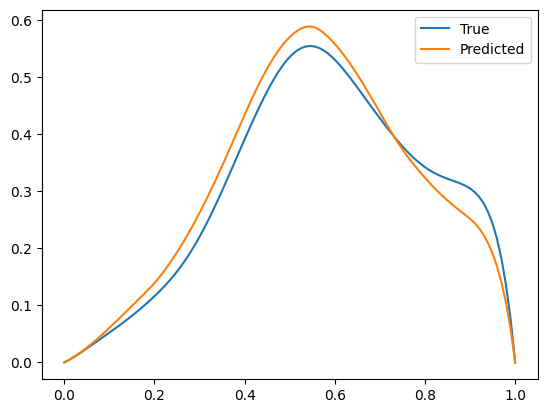

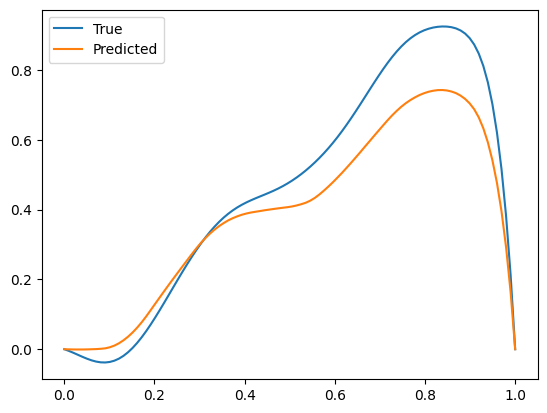

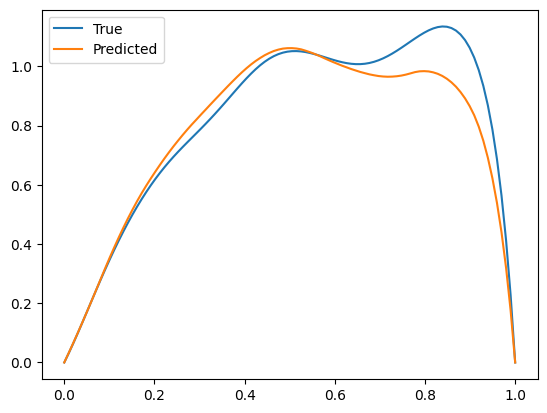

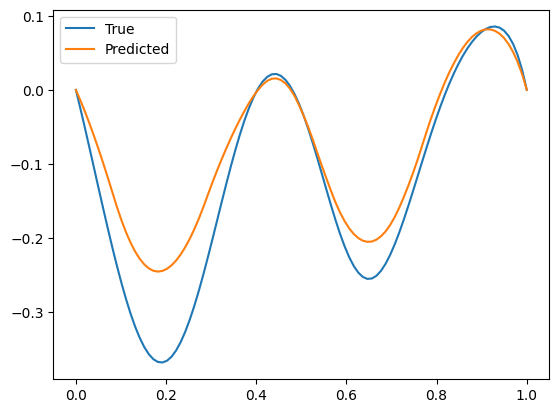

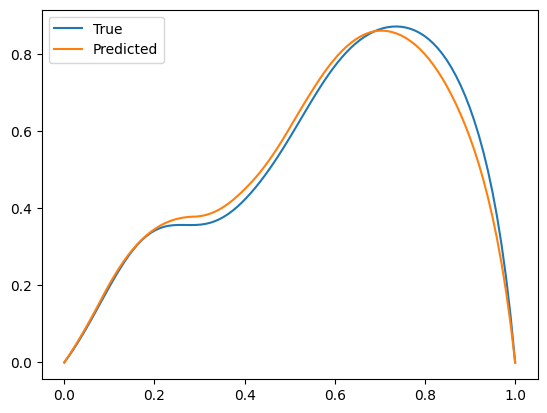

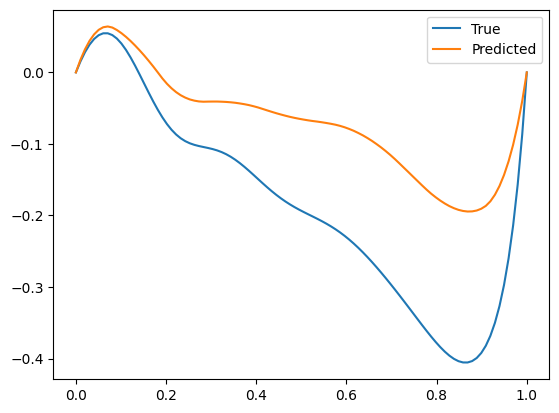

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:27:37,885 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:27:37,885 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007389
2025-08-06 10:27:37,886 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.006611
Training progress:  10%|█         | 1/10 [00:02<00:22,  2.53s/it]2025-08-06 10:27:40,366 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:27:40,367 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008293
2025-08-06 10:27:40,368 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.009828
Training progress:  20%|██        | 2/10 [00:05<00:20,  2.50s/it]2025-08-06 10:27:42,814 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:27:42,815 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007902
2025-08-06 10:27:42,816 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008217
Training progress:  30%|███       | 3/10 [00:07<00:17,  2.48s/i

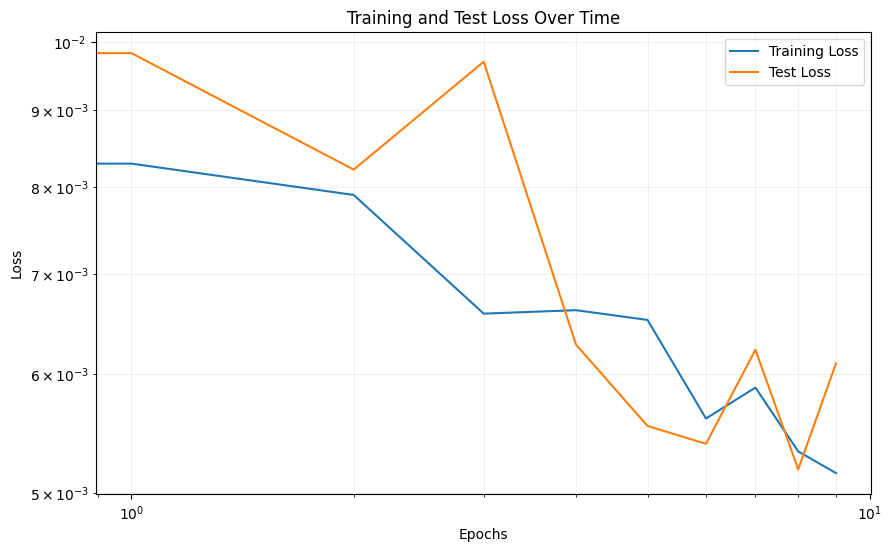

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


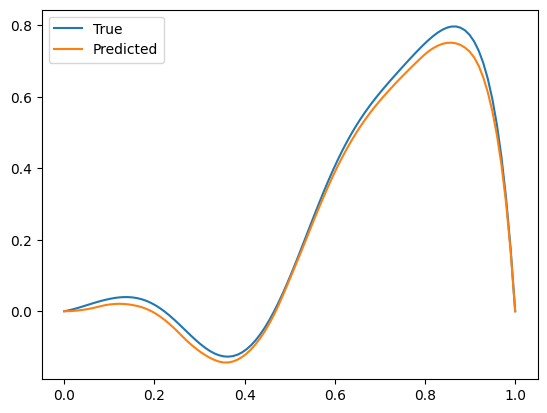

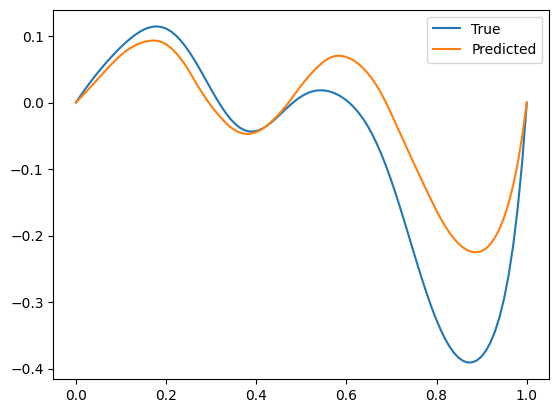

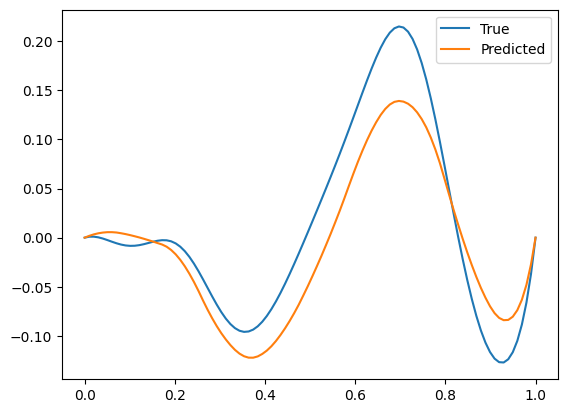

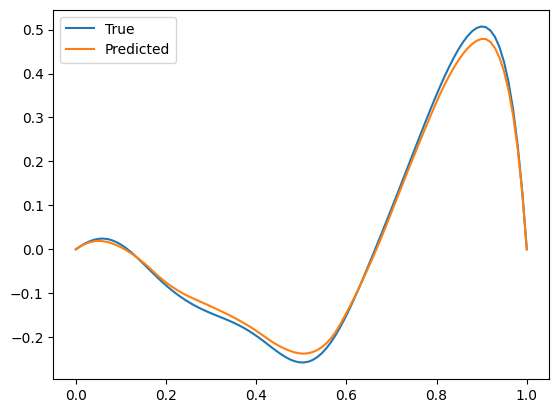

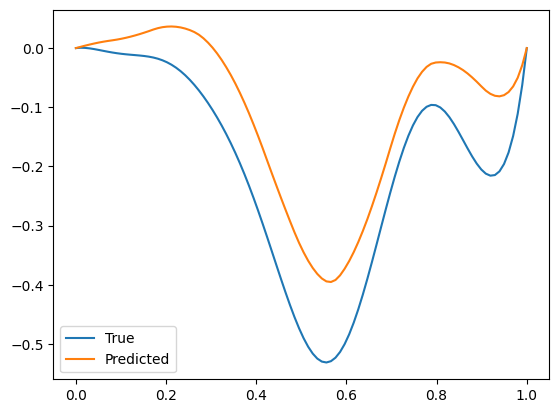

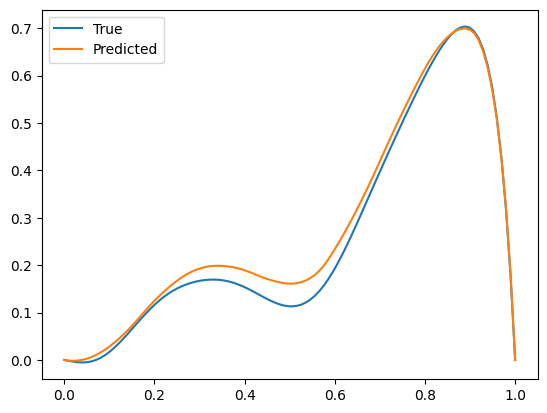

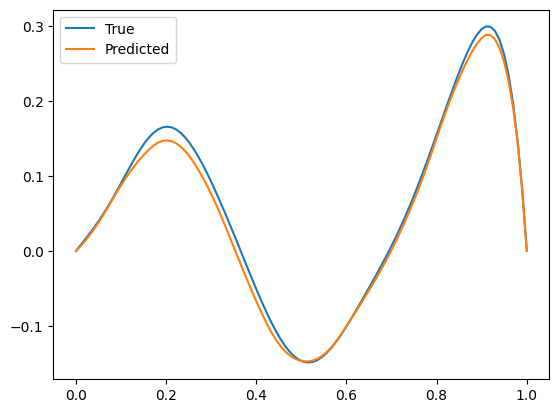

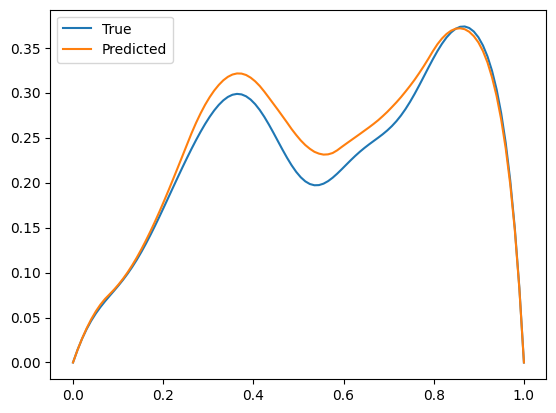

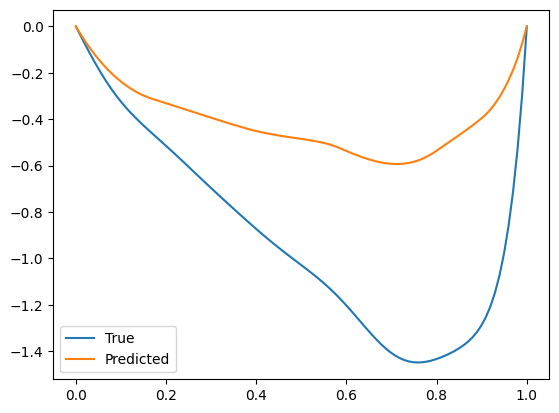

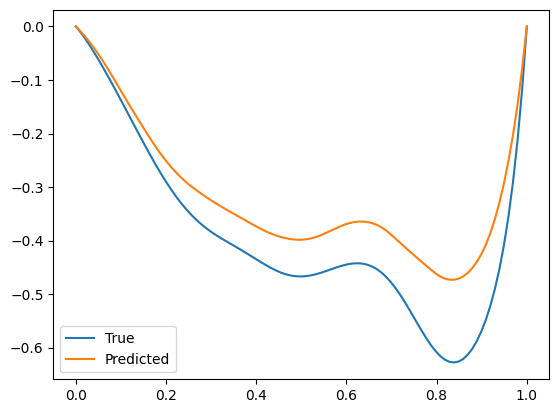

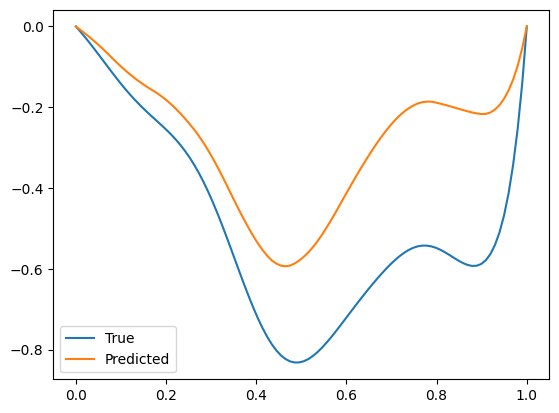

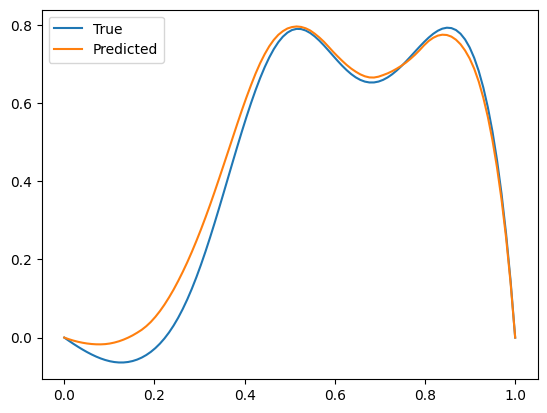

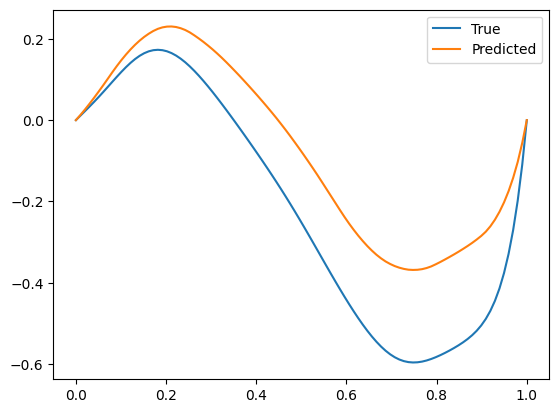

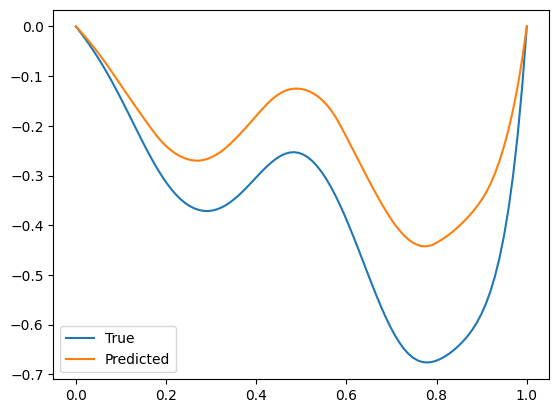

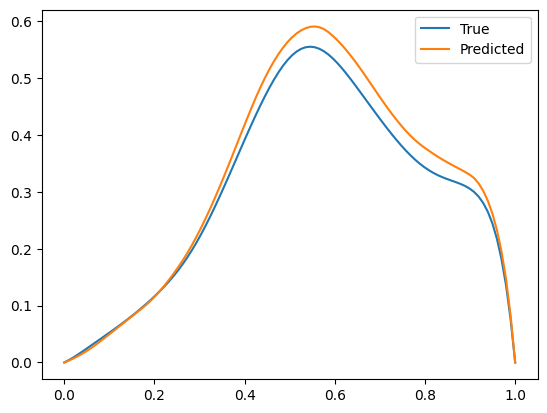

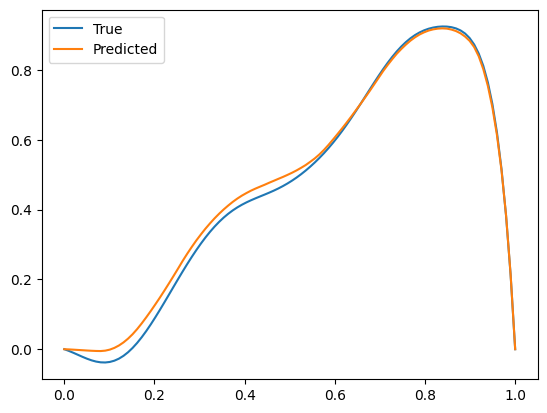

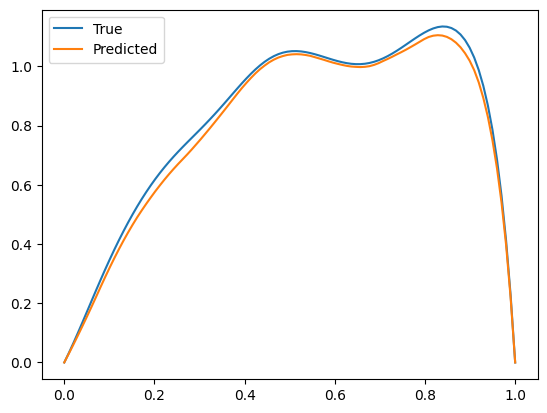

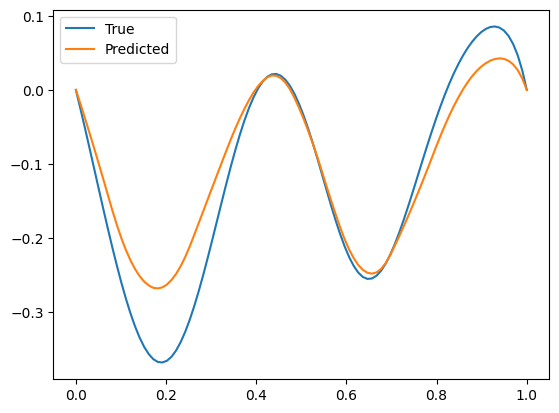

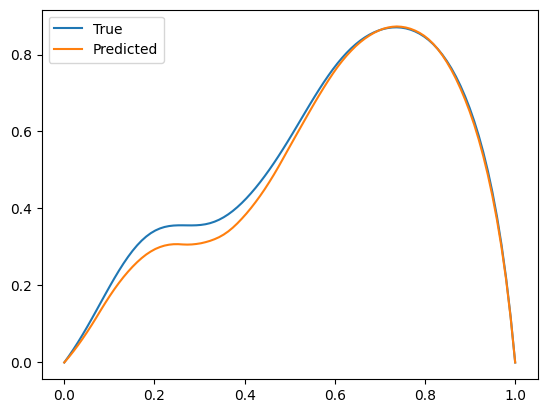

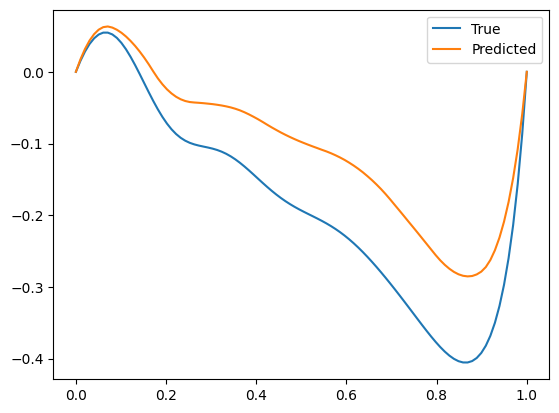

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 10:28:04.978676: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:28:08,557 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:28:08,558 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005230
2025-08-06 10:28:08,559 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.004969
Training progress:  10%|█         | 1/10 [00:03<00:31,  3.55s/it]2025-08-06 10:28:12,030 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:28:12,031 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.004783
2025-08-06 10:28:12,032 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.004896
Training progress:  20%|██        | 2/10 [00:07<00:28,  3.51s/it]2025-08-06 10:28:15,509 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:28:15,510 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.00

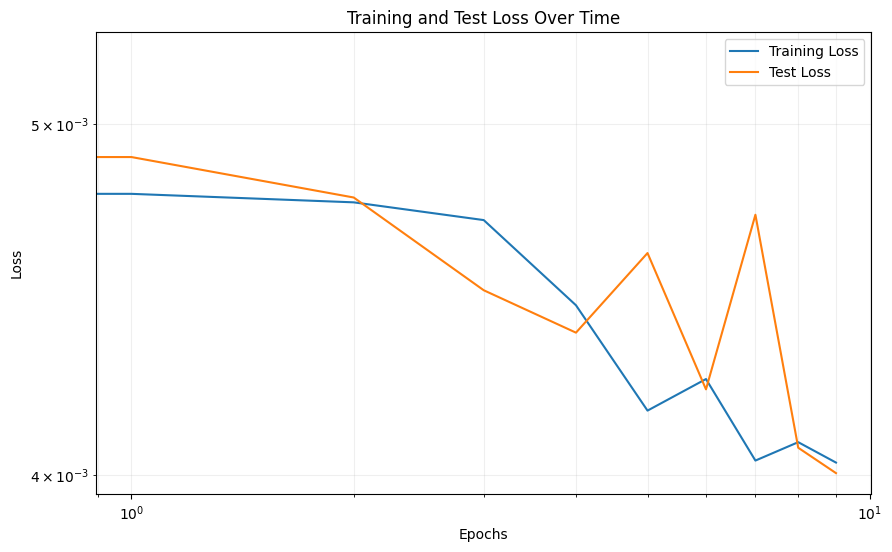

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


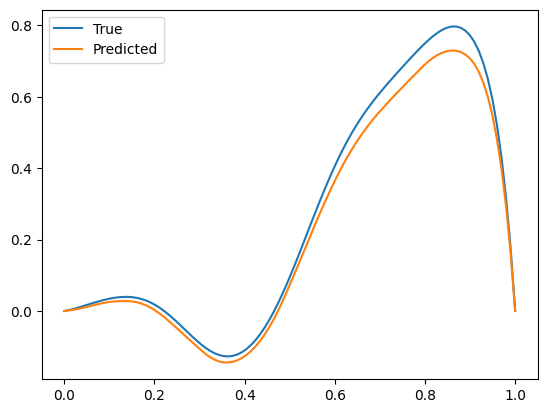

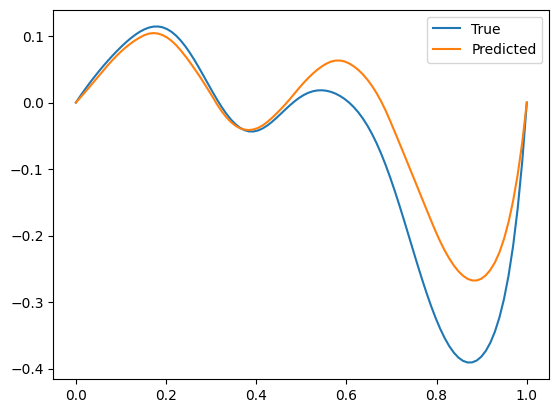

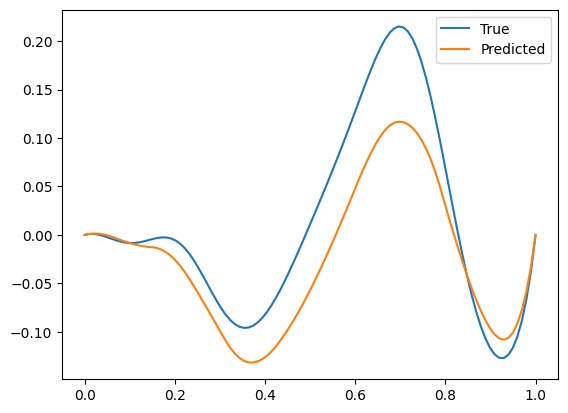

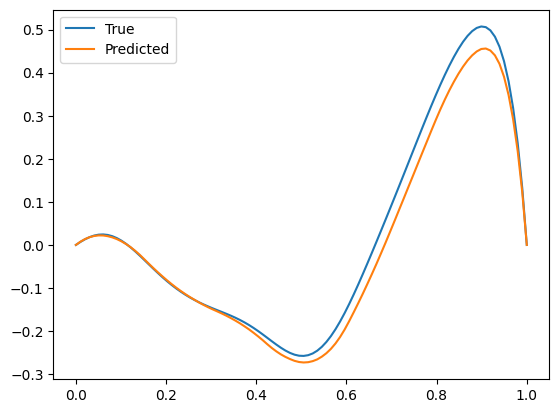

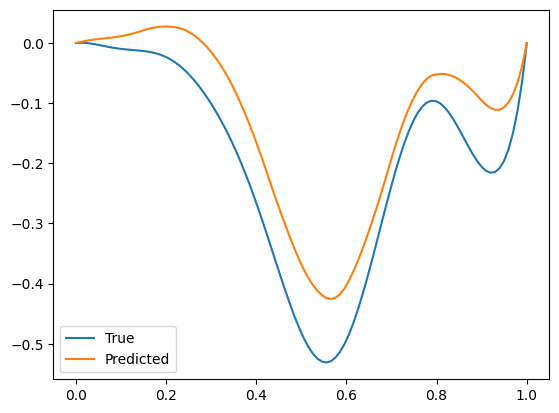

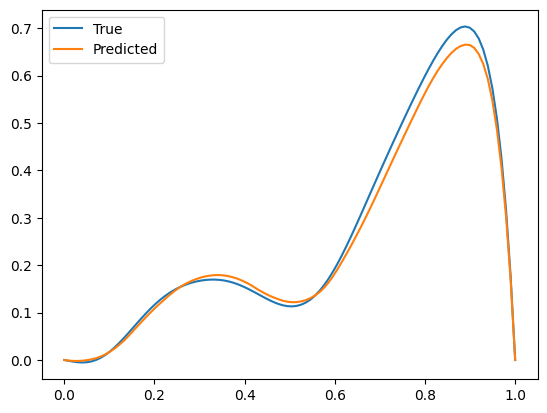

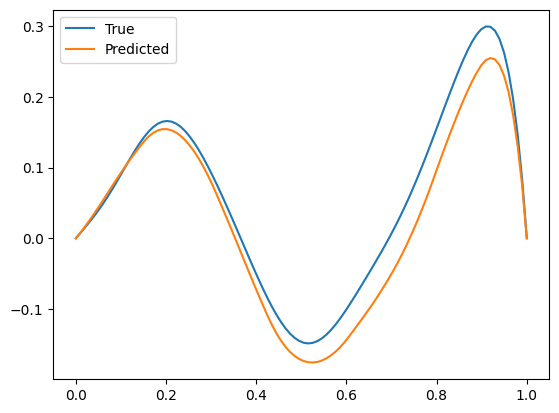

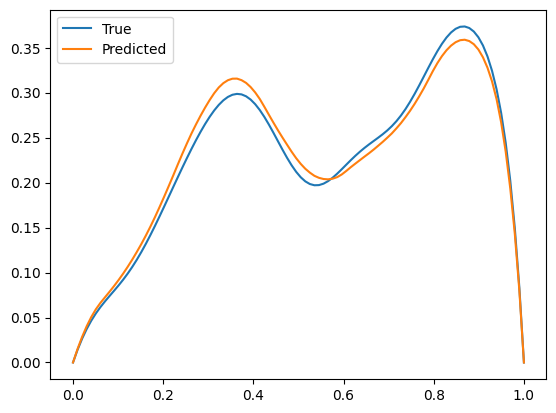

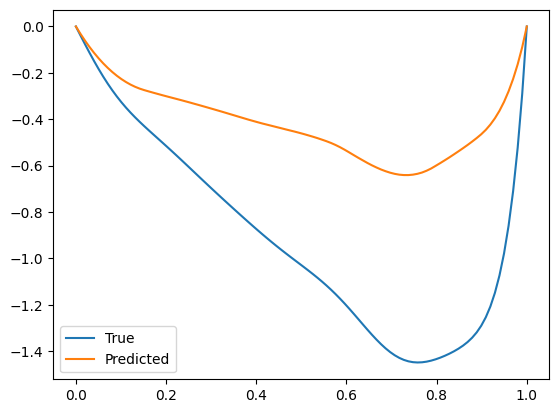

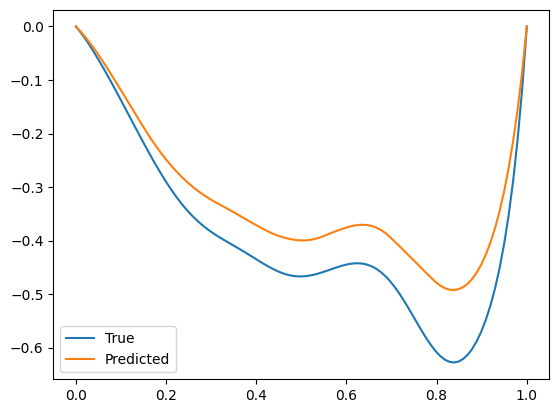

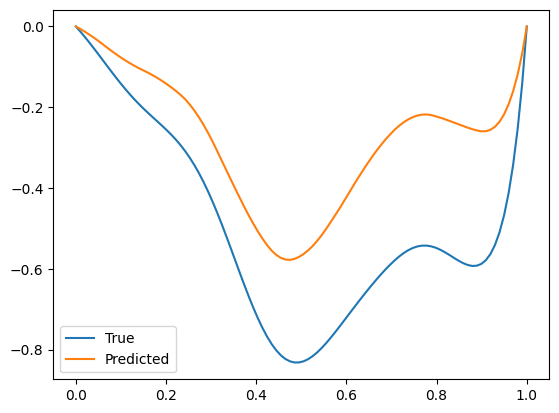

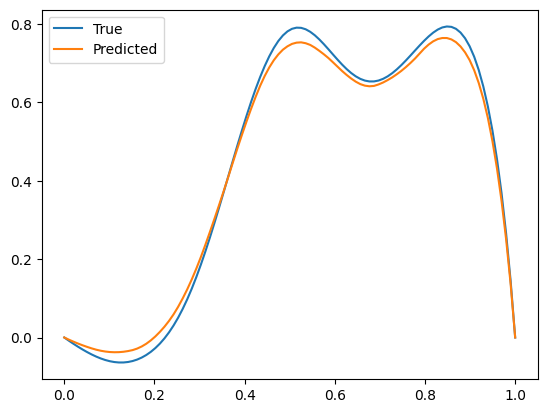

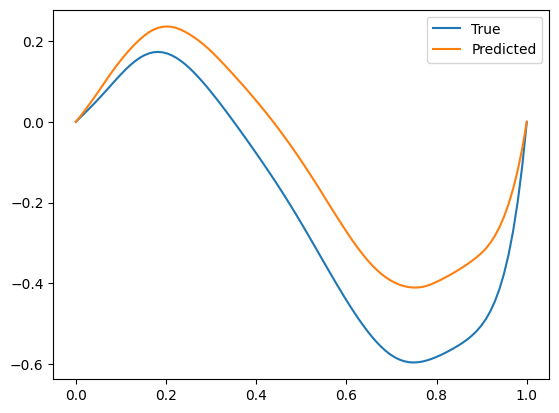

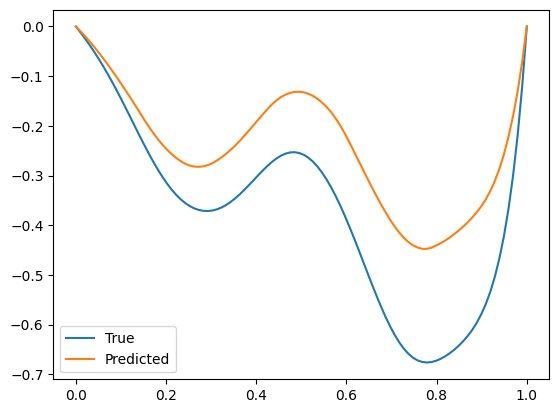

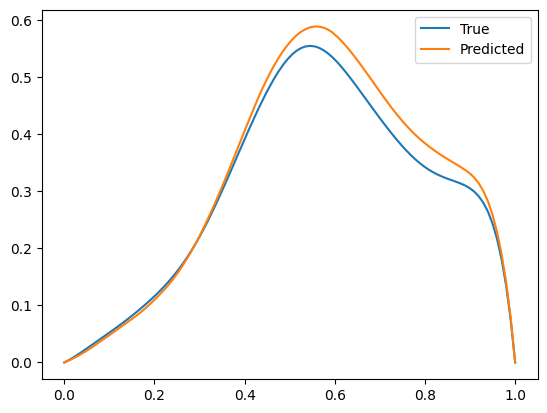

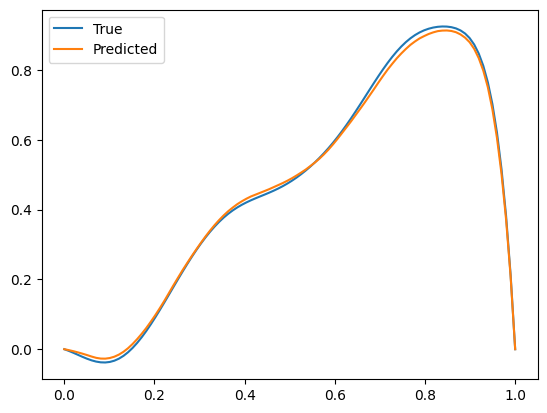

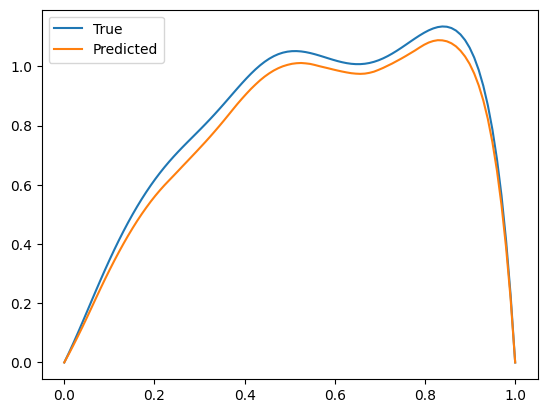

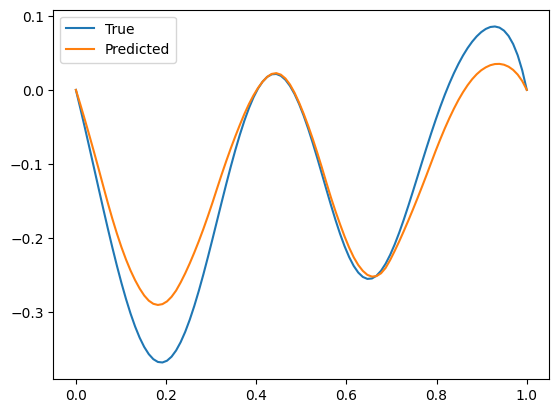

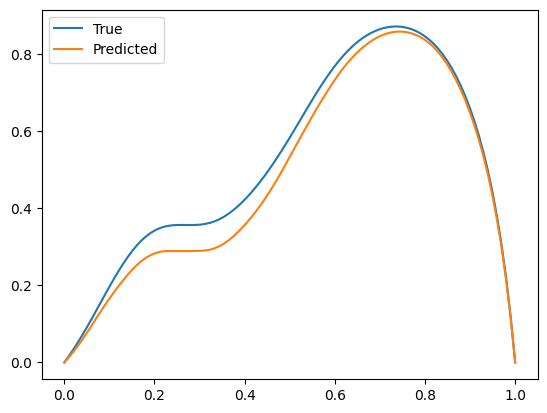

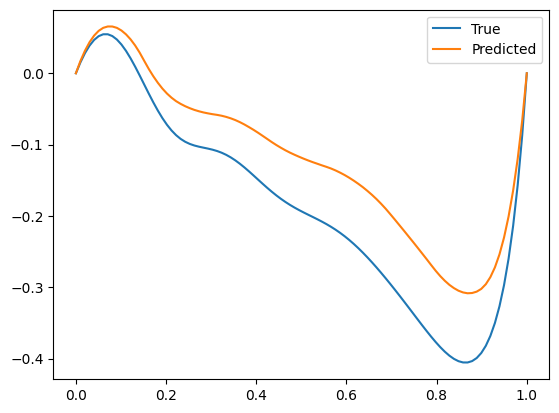

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:28:48,494 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:28:48,495 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003589
2025-08-06 10:28:48,495 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003449
Training progress:  10%|█         | 1/10 [00:02<00:22,  2.55s/it]2025-08-06 10:28:50,915 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:28:50,916 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003326
2025-08-06 10:28:50,917 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003579
Training progress:  20%|██        | 2/10 [00:04<00:19,  2.48s/it]2025-08-06 10:28:53,345 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:28:53,346 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003332
2025-08-06 10:28:53,346 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003568
Training progress:  30%|███       | 3/10 [00:07<00:17,  2.45s/i

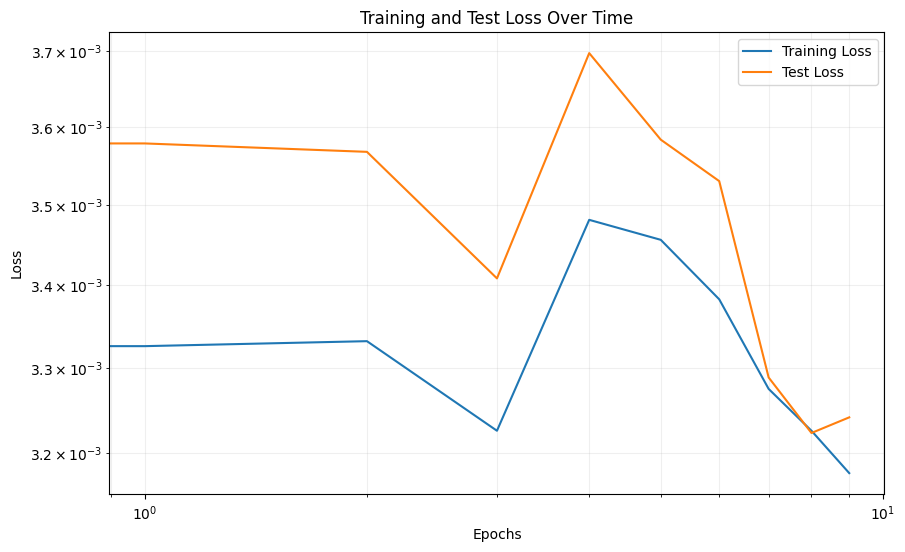

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


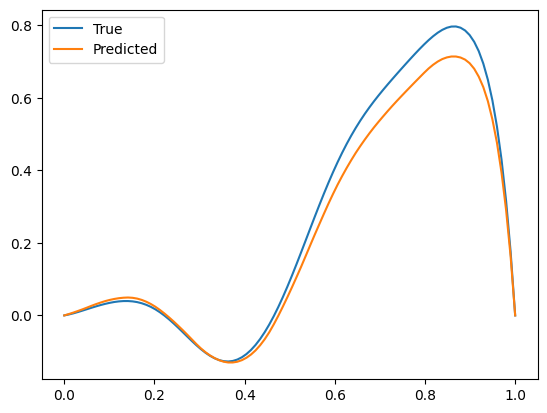

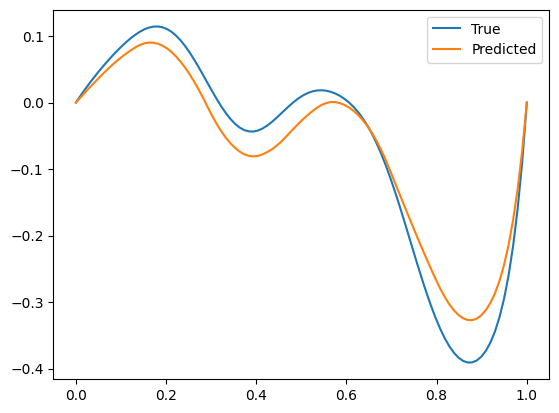

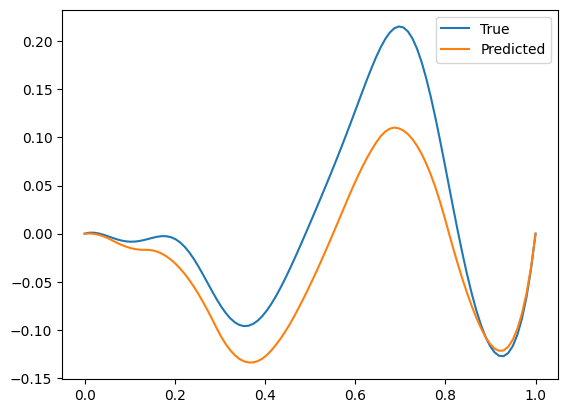

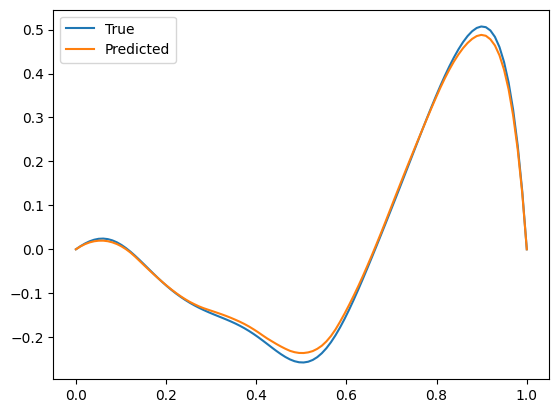

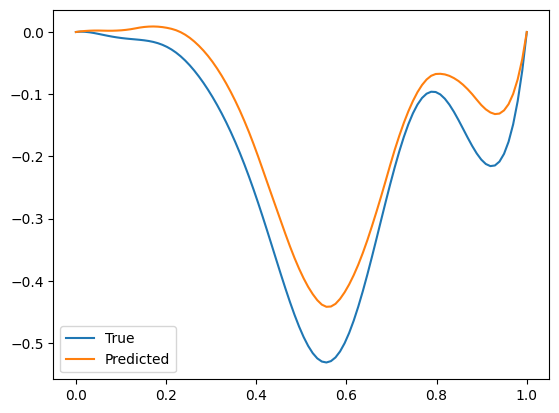

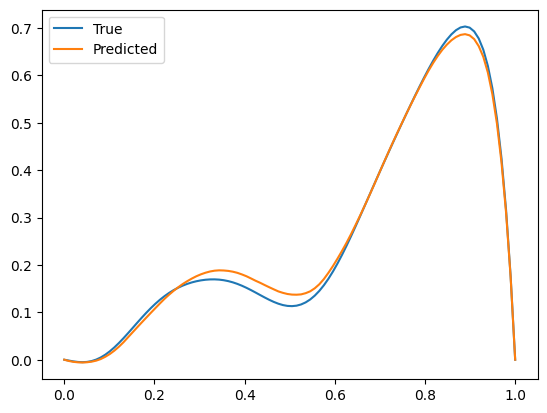

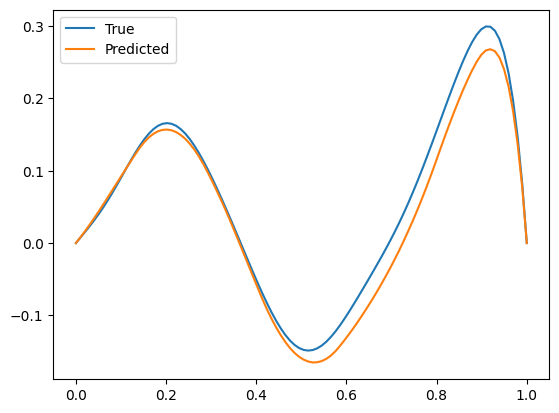

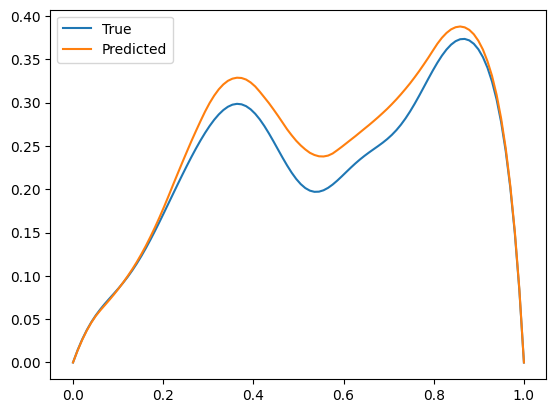

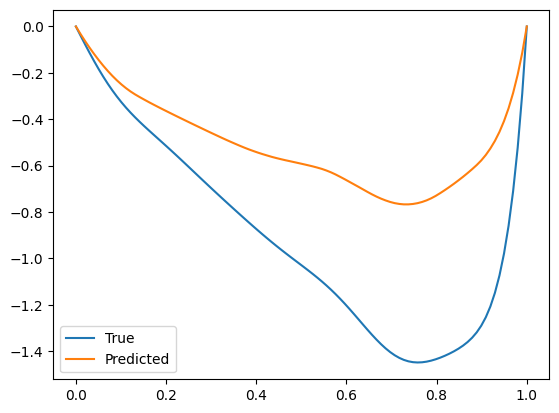

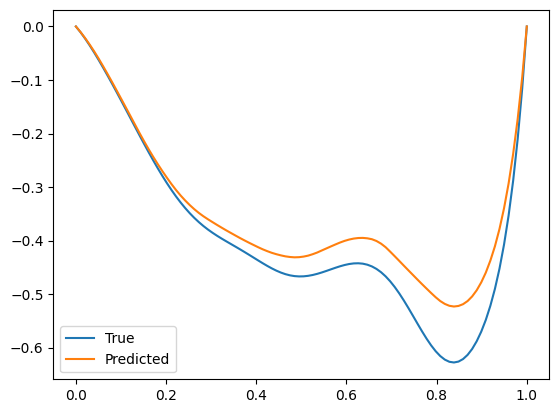

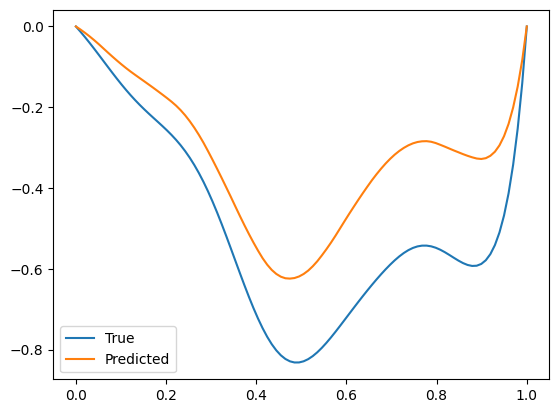

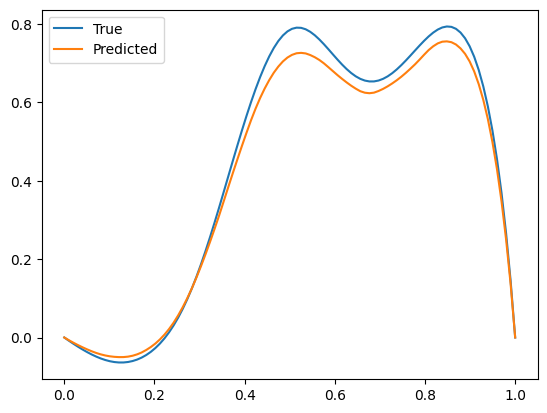

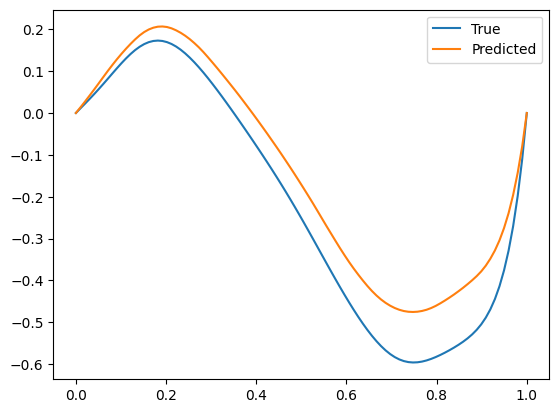

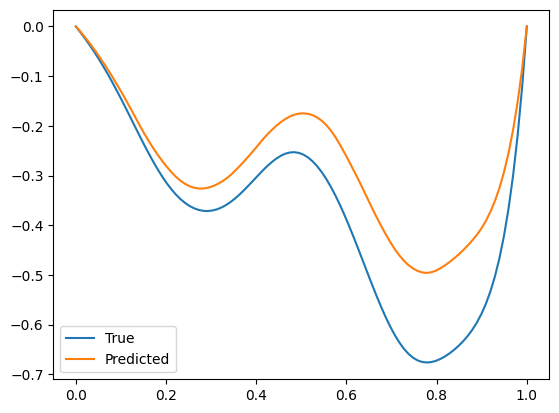

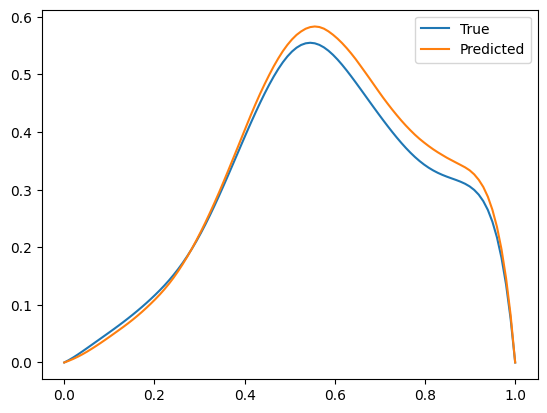

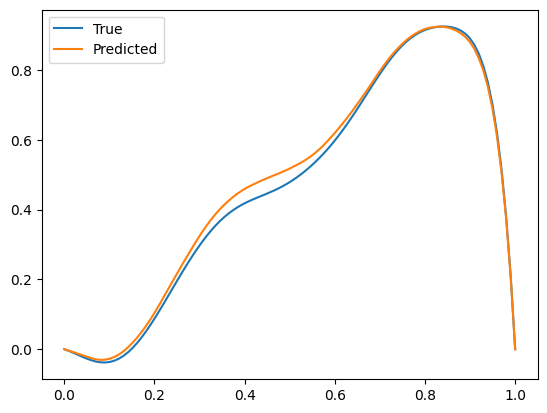

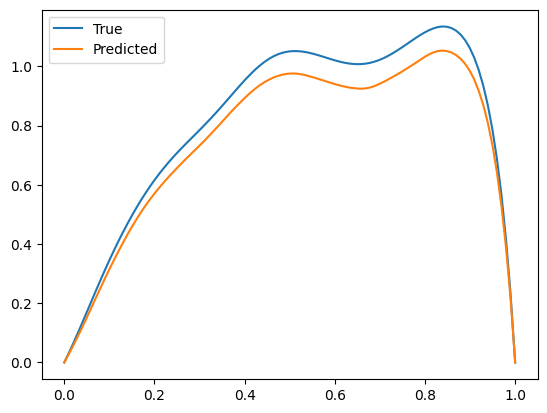

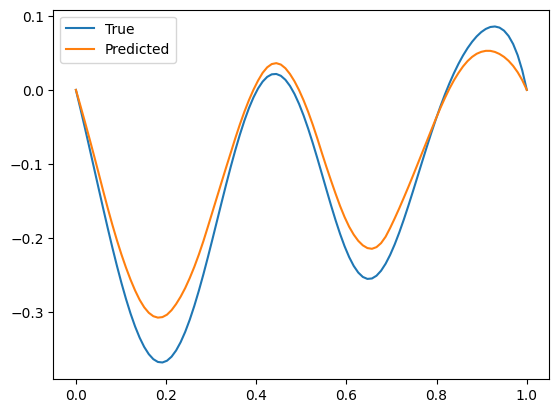

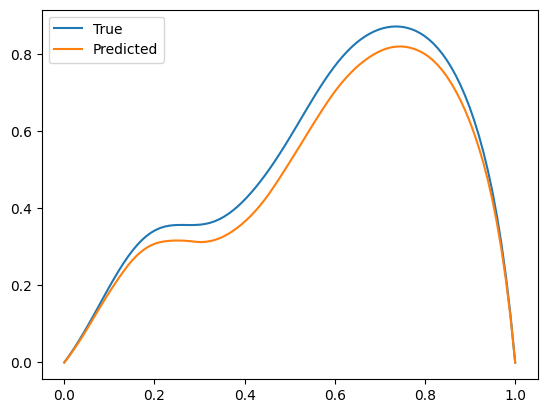

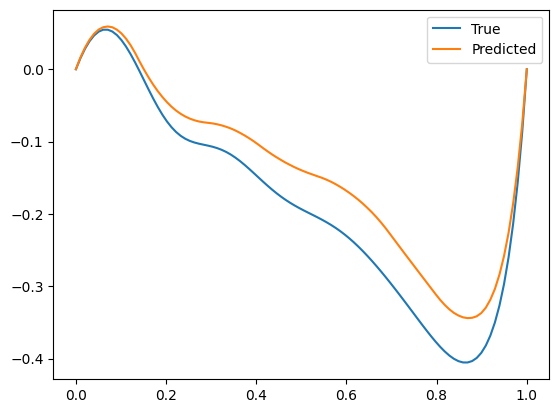

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:29:20,247 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:29:20,247 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003153
2025-08-06 10:29:20,248 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003223
Training progress:  10%|█         | 1/10 [00:03<00:34,  3.89s/it]2025-08-06 10:29:23,850 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:29:23,851 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003077
2025-08-06 10:29:23,851 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003163
Training progress:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]2025-08-06 10:29:27,495 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:29:27,496 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003028
2025-08-06 10:29:27,497 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003173
Training progress:  30%|███       | 3/10 [00:11<00:25,  3.69s/i

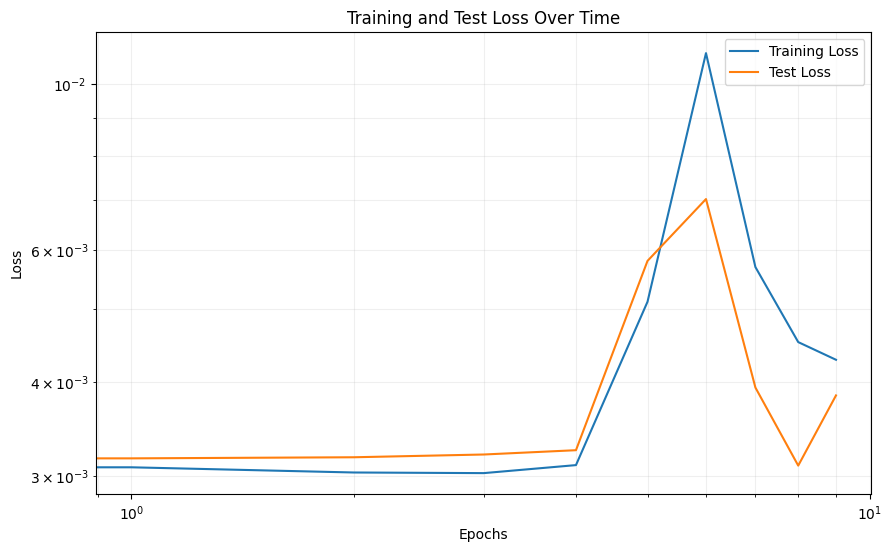

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


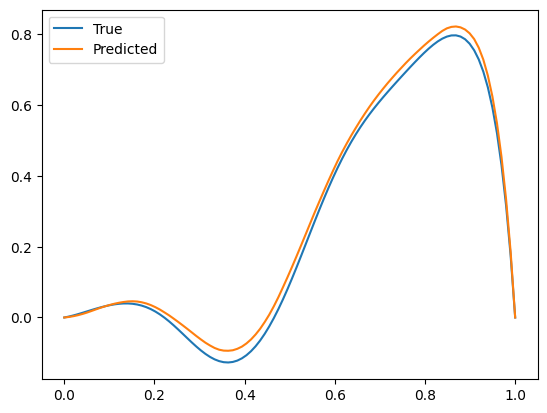

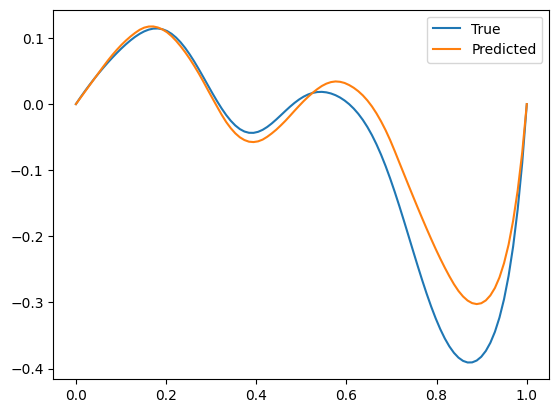

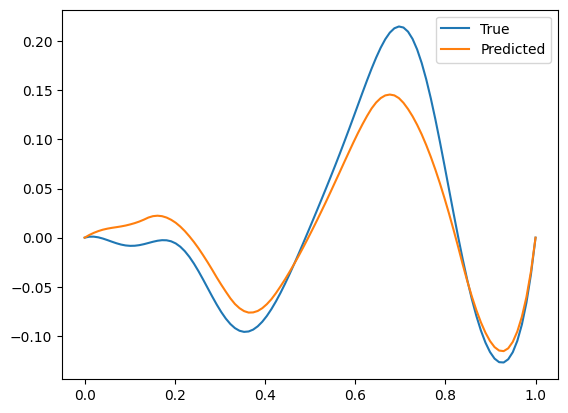

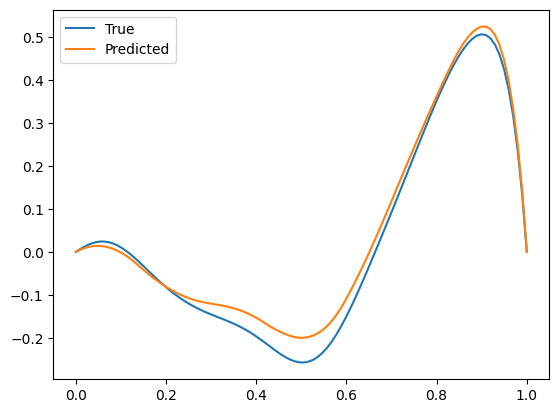

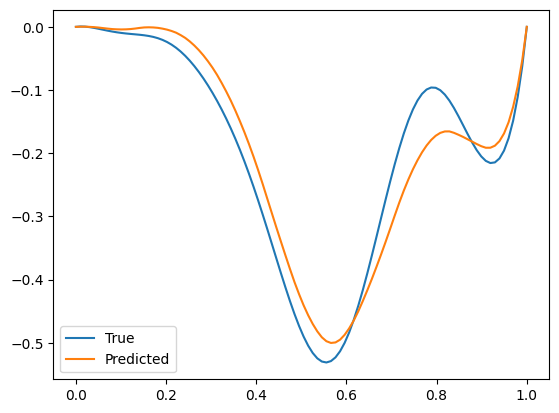

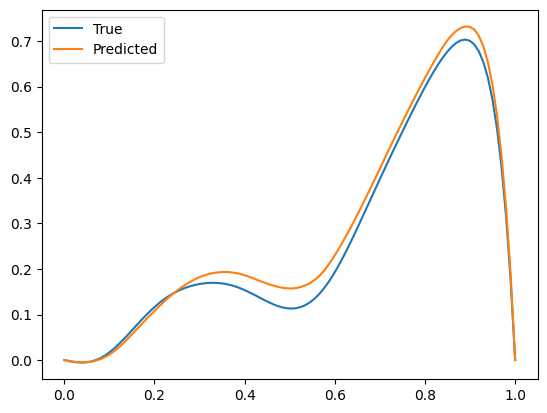

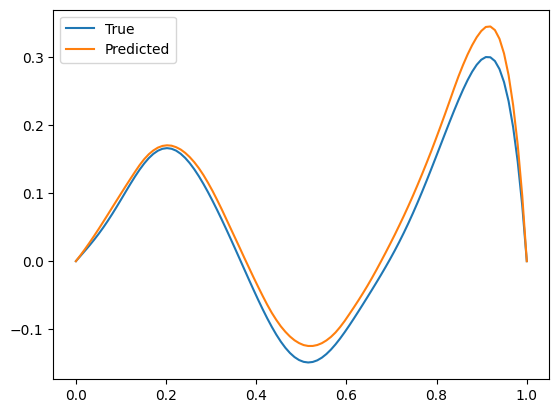

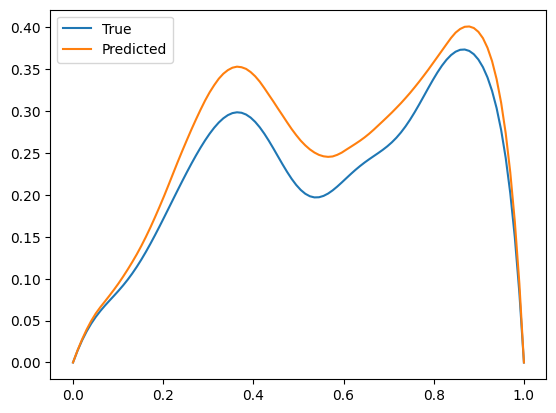

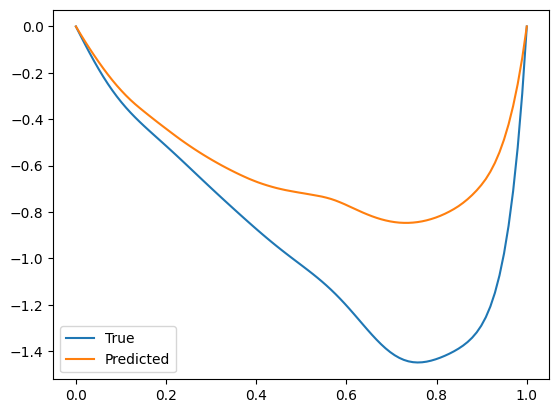

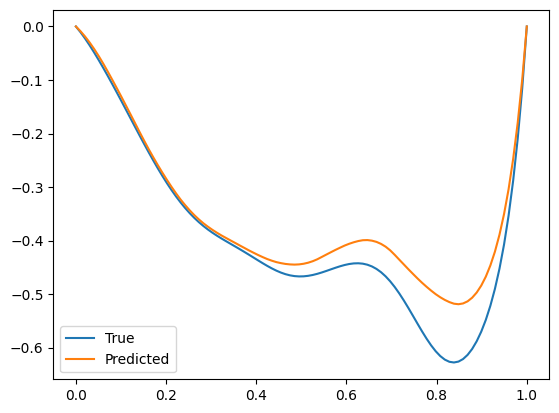

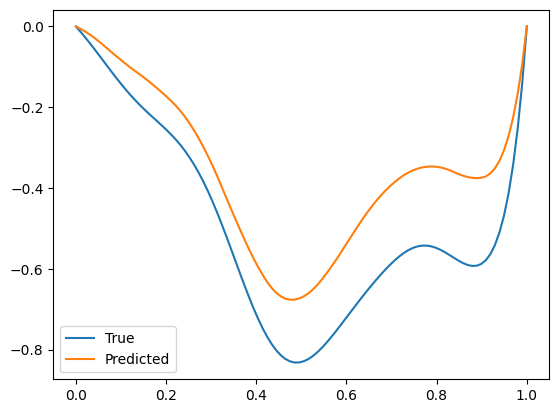

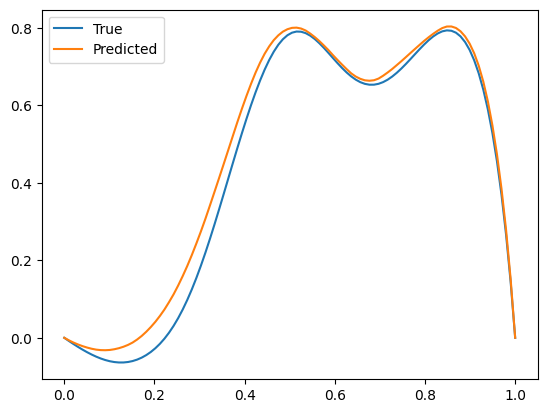

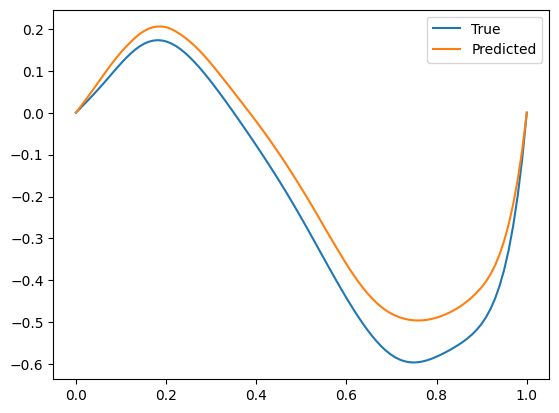

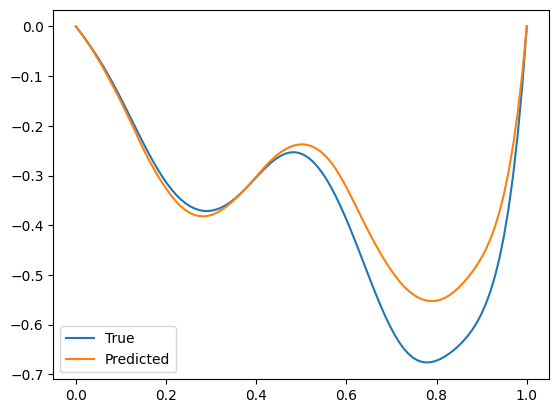

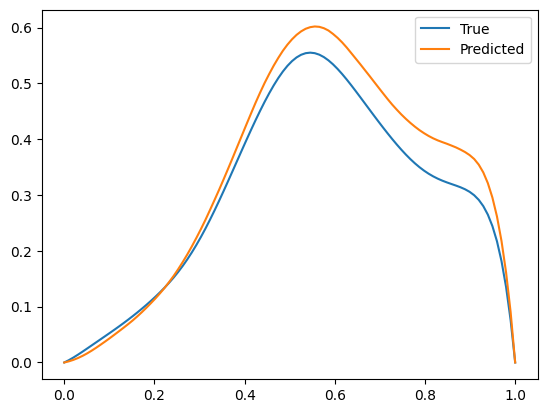

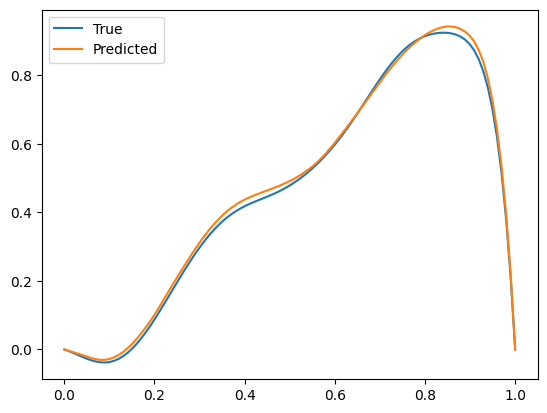

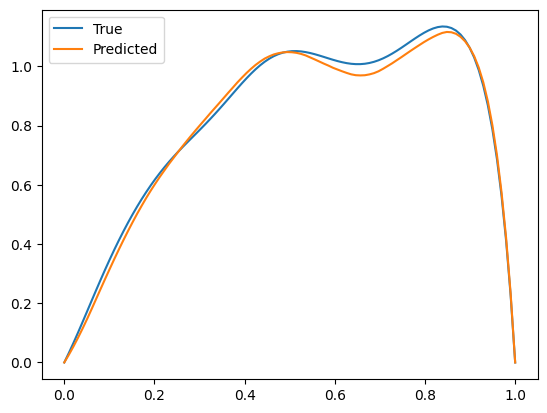

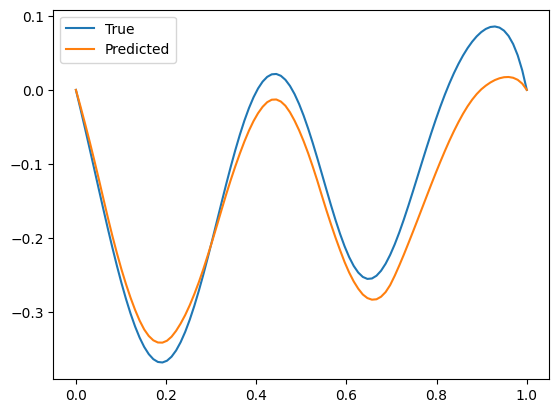

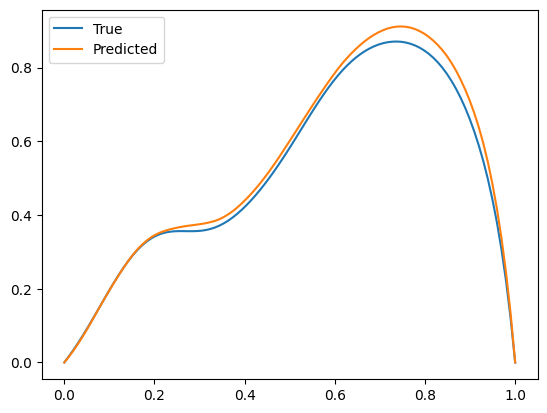

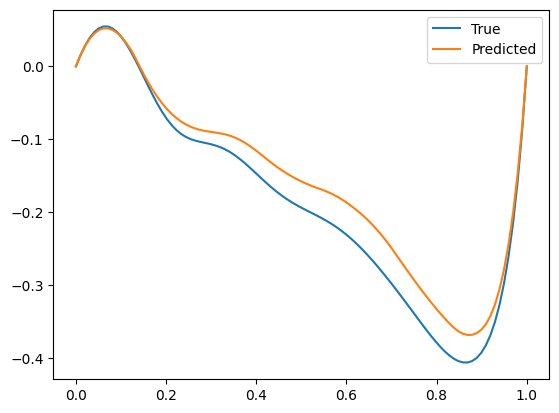

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:29:59.533781: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 10:29:59,711 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:29:59,712 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005644
2025-08-06 10:29:59,713 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011774
Training progress:  10%|█         | 1/10 [00:02<00:23,  2.63s/it]2025-08-06 10:30:02,275 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:30:02,276 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008341
2025-08-06 10:30:02,276 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.005575
Training progress:  20%|██        | 2/10 [00:05<00:20,  2.59s/it]2025-08-06 10:30:05,014 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:30:05,016 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.00

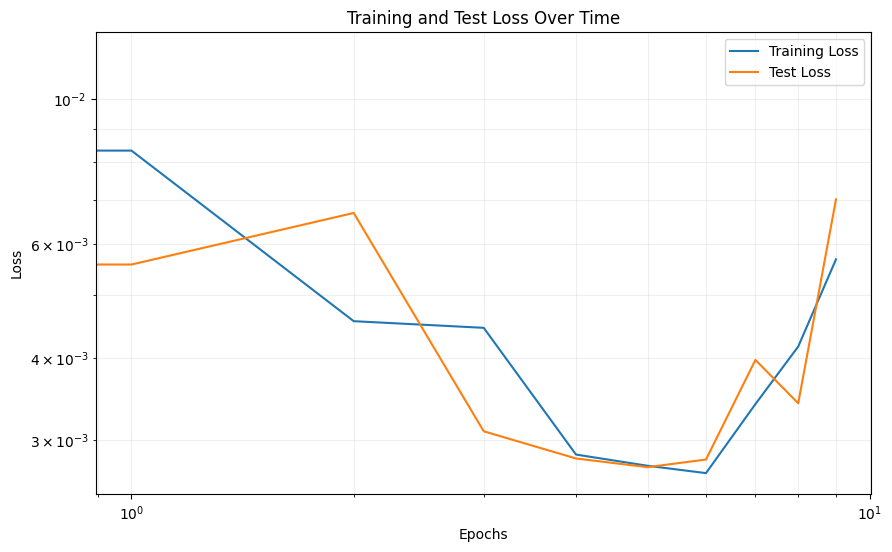

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


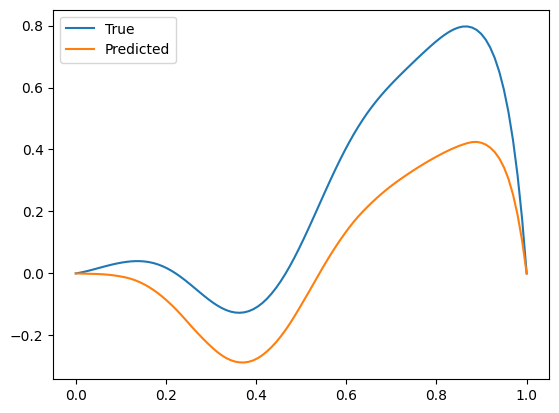

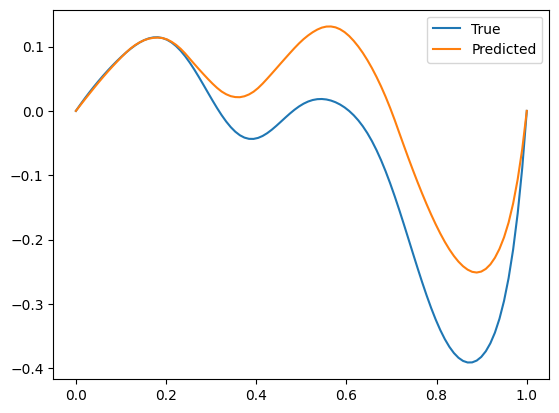

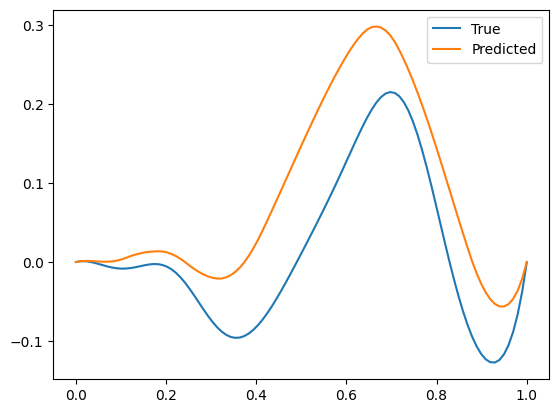

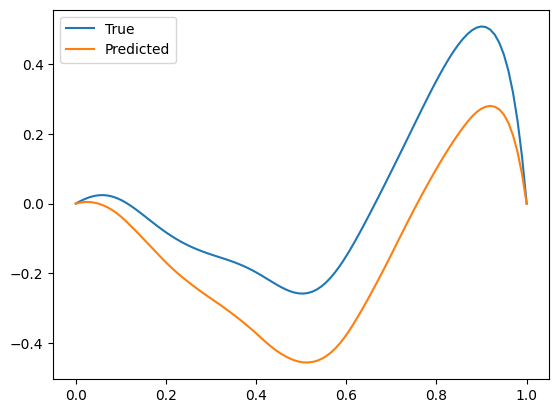

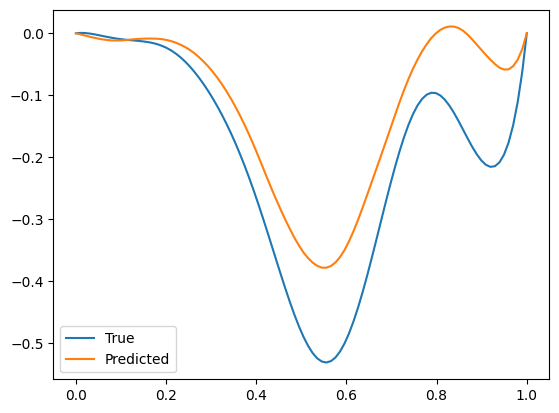

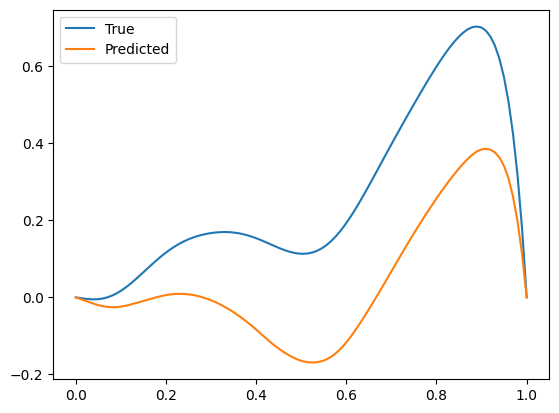

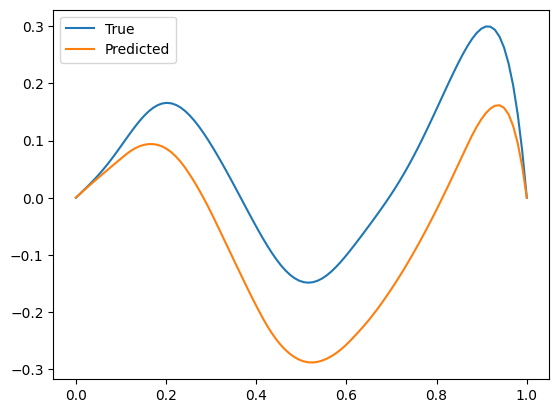

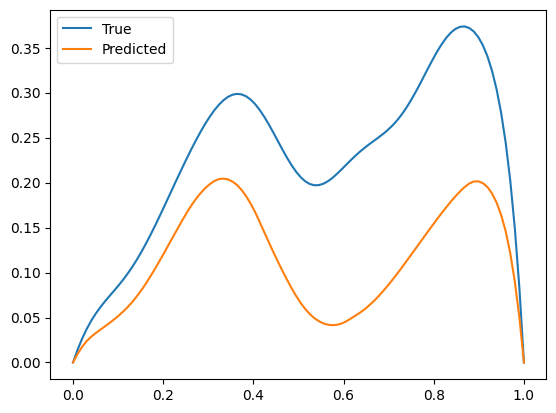

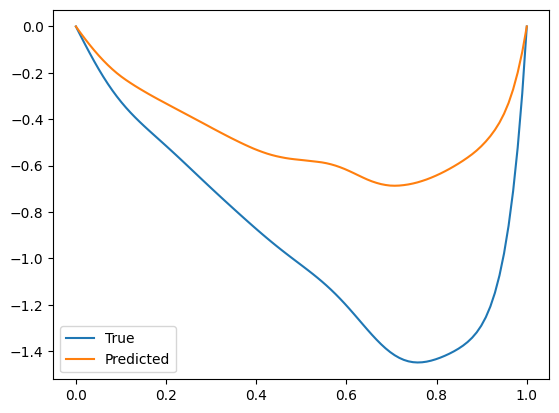

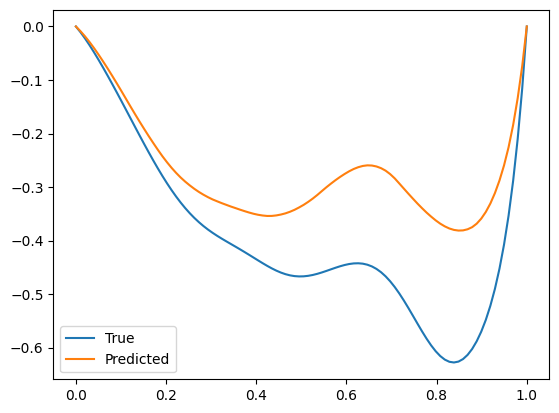

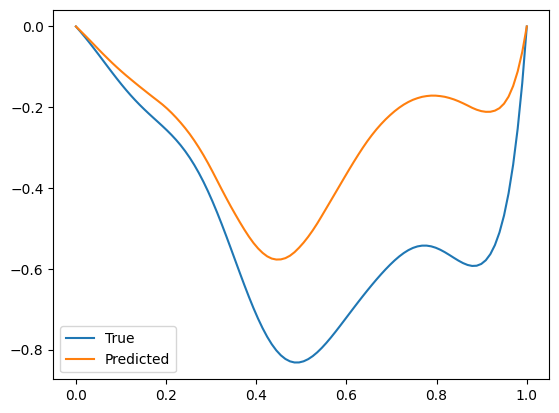

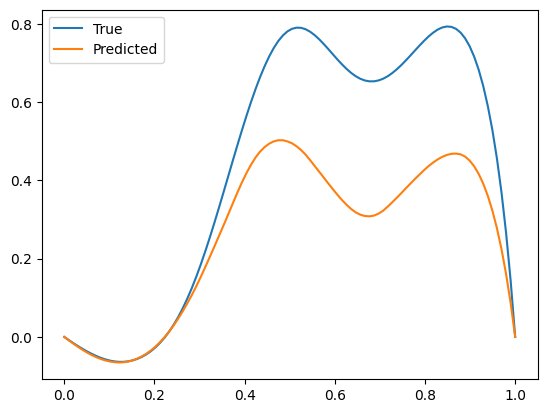

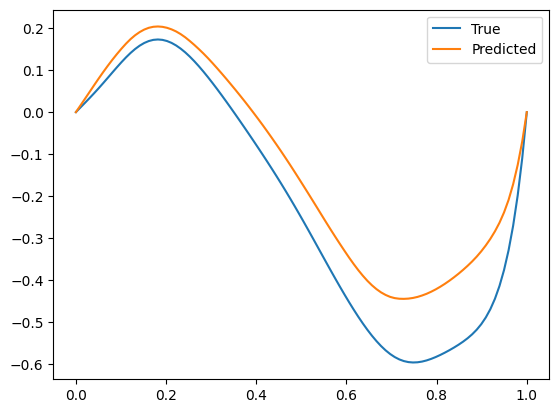

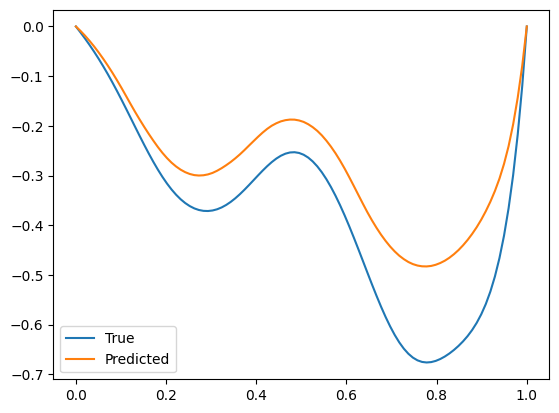

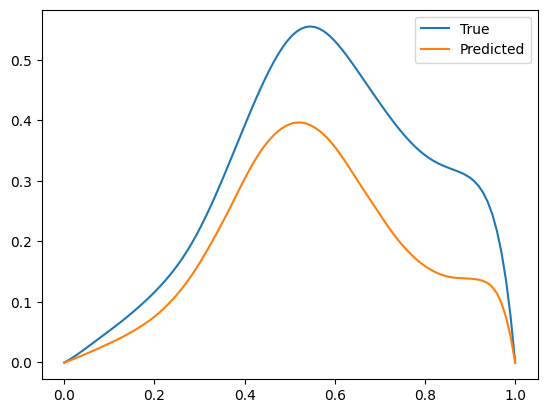

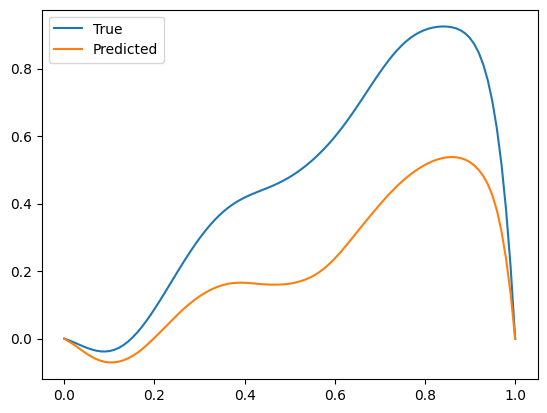

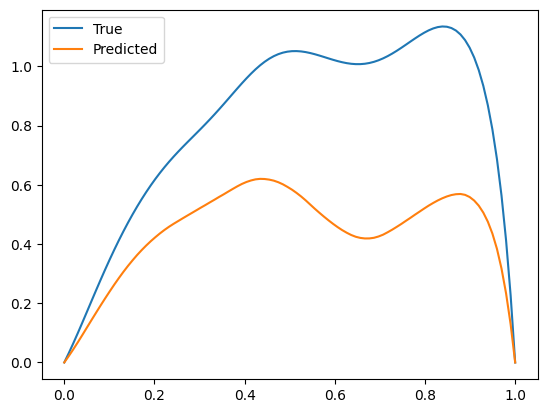

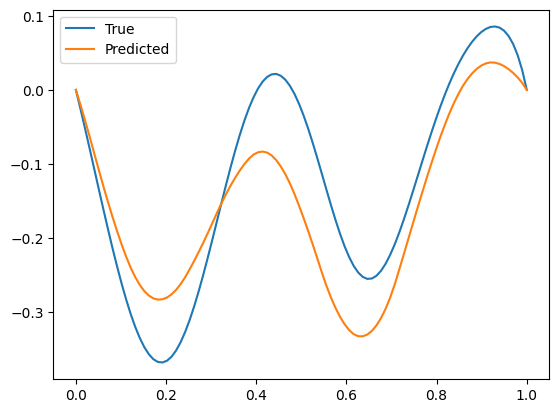

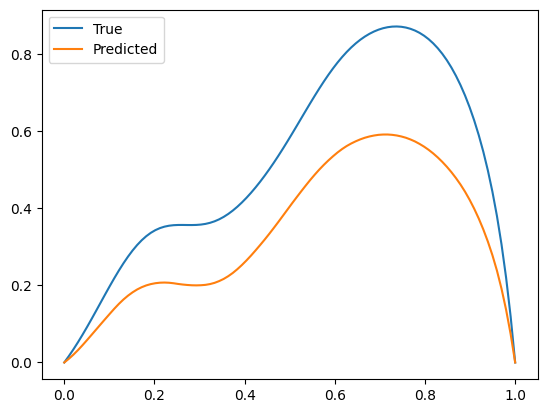

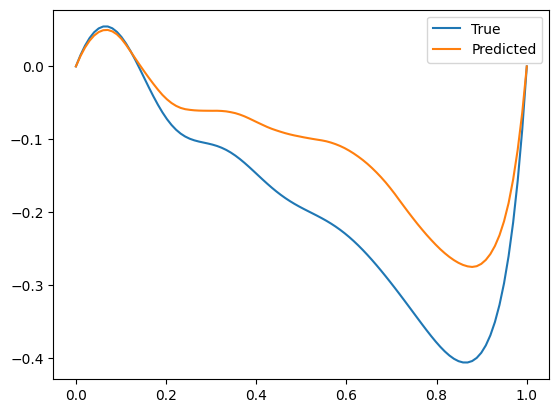

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:30:30,571 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:30:30,573 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005026
2025-08-06 10:30:30,573 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003042
Training progress:  10%|█         | 1/10 [00:02<00:24,  2.71s/it]2025-08-06 10:30:33,213 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:30:33,214 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005314
2025-08-06 10:30:33,215 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.010594
Training progress:  20%|██        | 2/10 [00:05<00:21,  2.67s/it]2025-08-06 10:30:35,826 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:30:35,827 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.004253
2025-08-06 10:30:35,828 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.005039
Training progress:  30%|███       | 3/10 [00:07<00:18,  2.64s/i

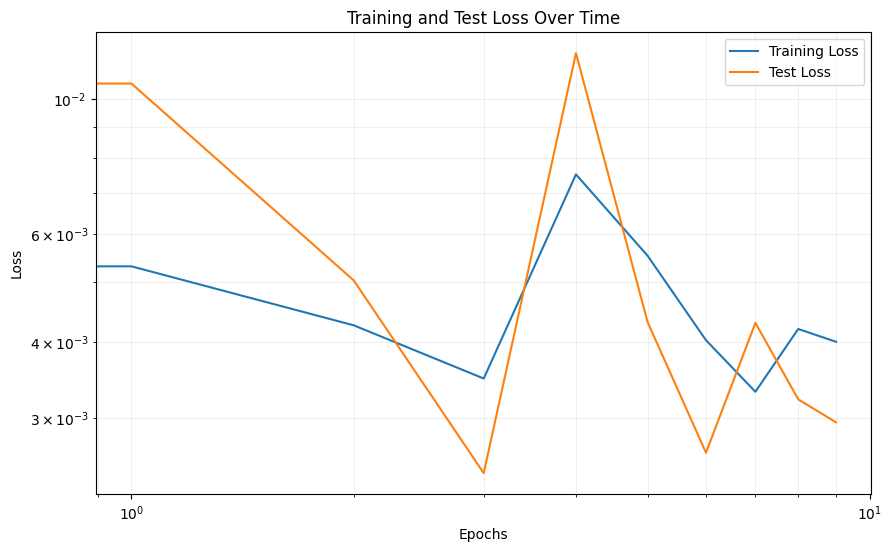

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


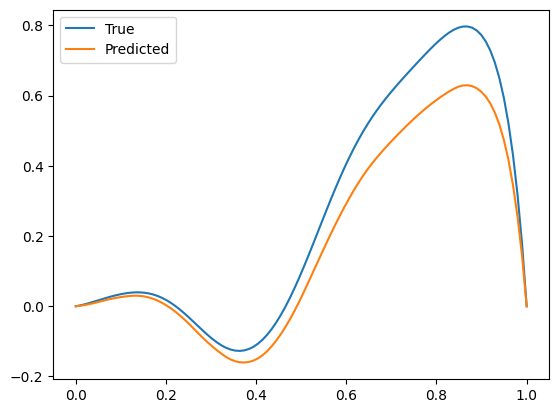

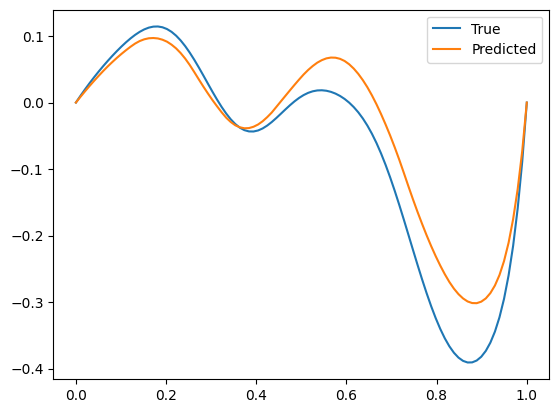

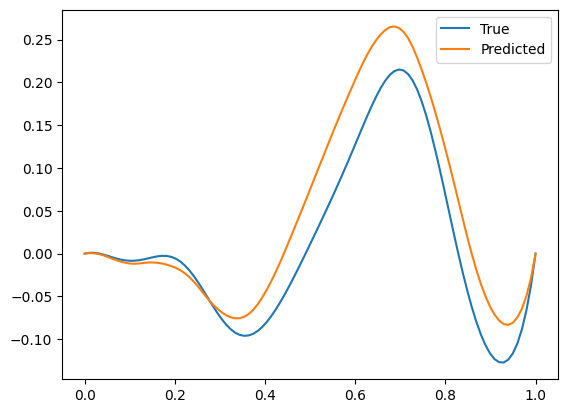

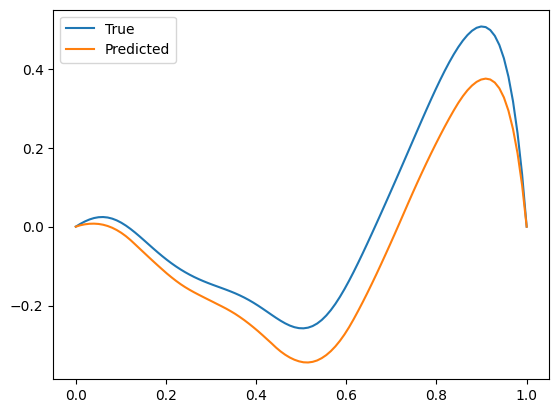

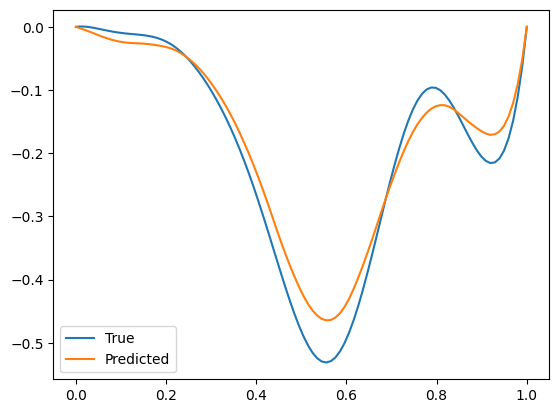

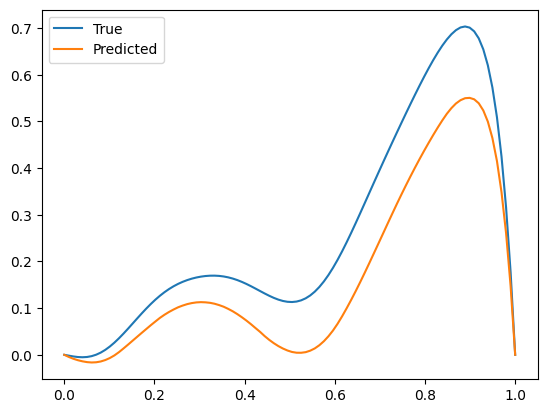

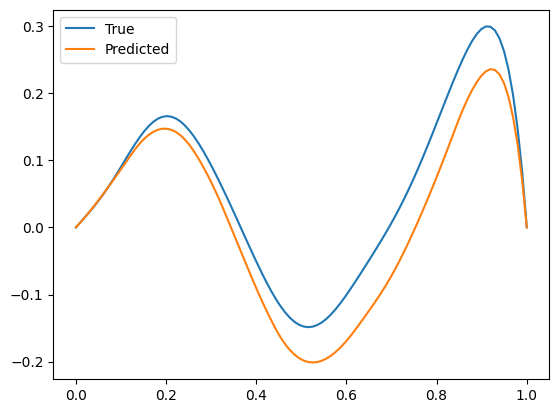

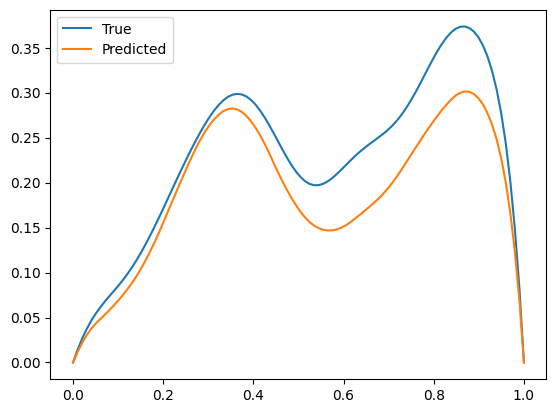

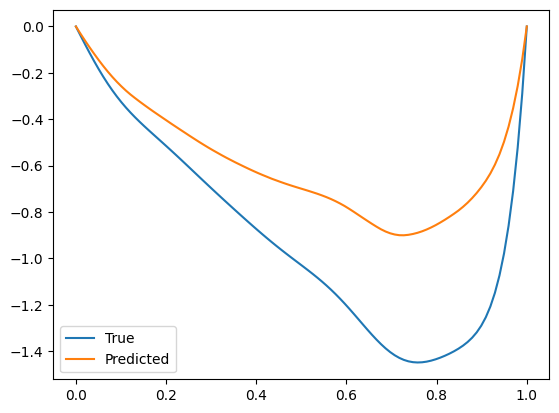

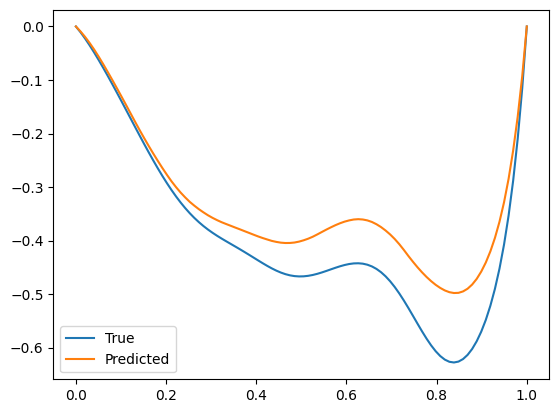

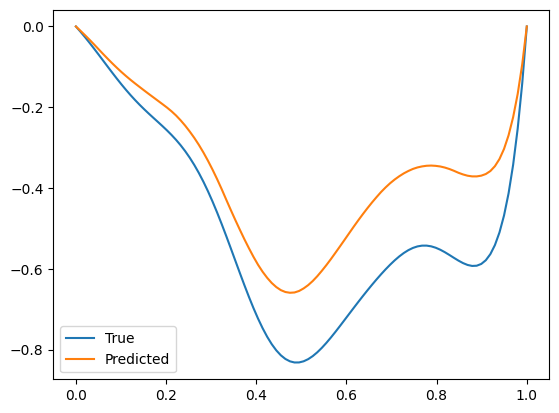

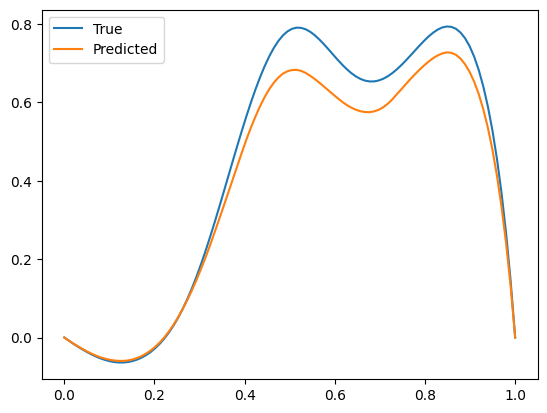

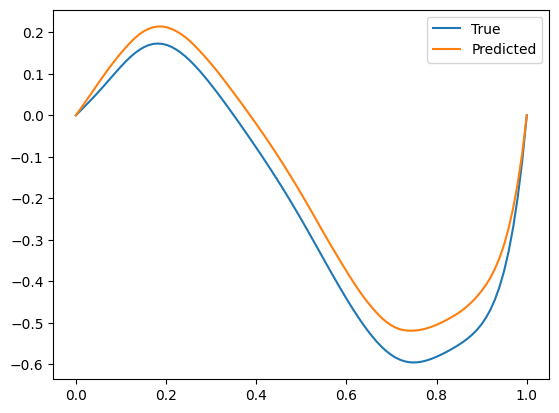

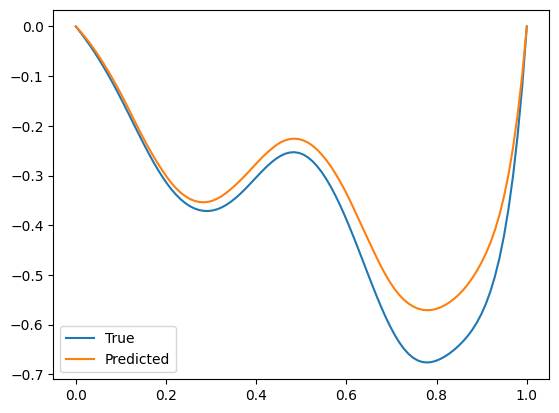

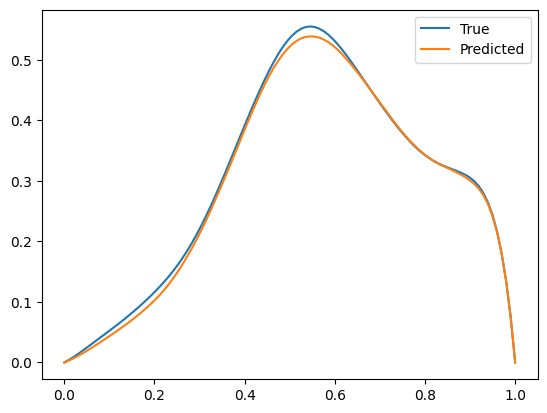

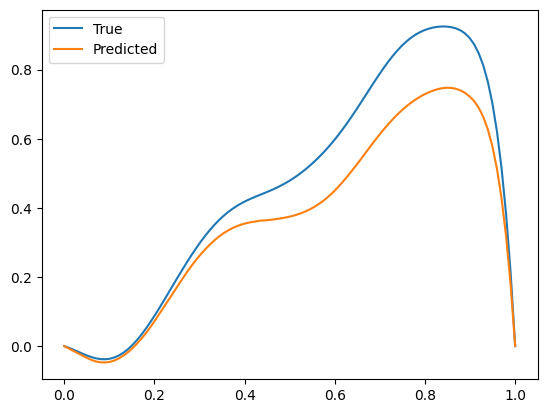

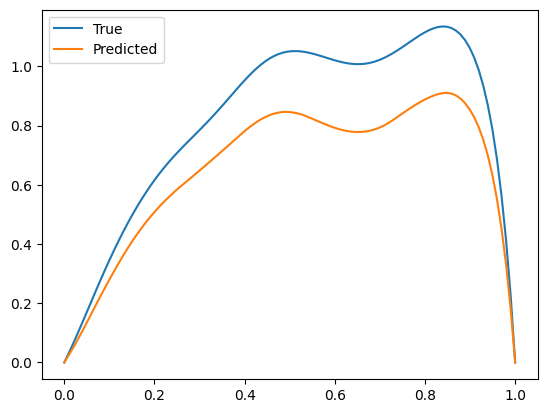

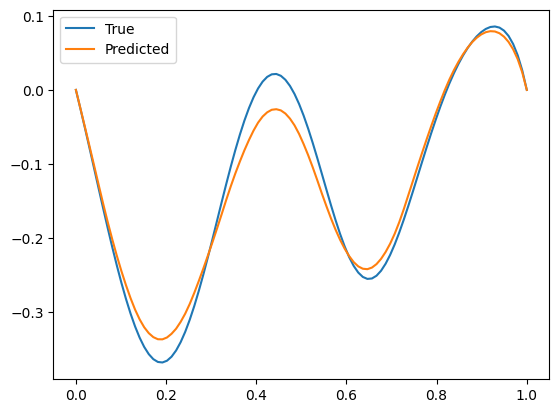

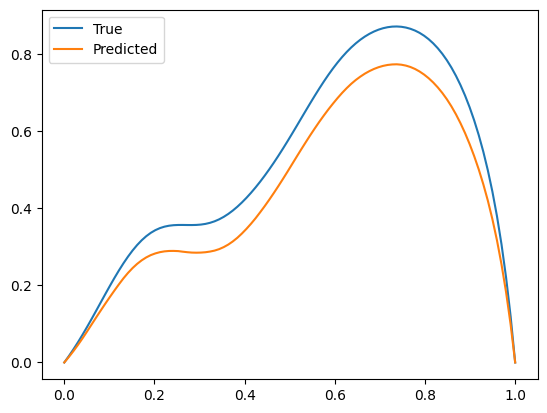

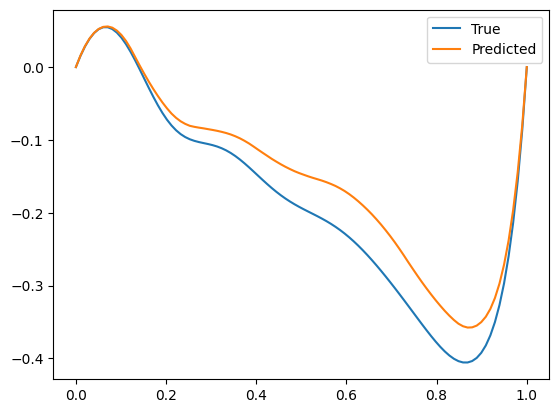

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:31:02,366 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:31:02,366 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.004157
2025-08-06 10:31:02,367 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008891
Training progress:  10%|█         | 1/10 [00:03<00:32,  3.62s/it]2025-08-06 10:31:06,004 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:31:06,005 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007129
2025-08-06 10:31:06,005 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.006247
Training progress:  20%|██        | 2/10 [00:07<00:29,  3.63s/it]2025-08-06 10:31:09,621 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:31:09,622 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005966
2025-08-06 10:31:09,622 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.010199
Training progress:  30%|███       | 3/10 [00:10<00:25,  3.62s/i

In [ ]:
for _ in range(10):
    train_history = model.fit()
    plt.figure(figsize=(10,6))
    plt.plot(train_history[0], label='Training Loss')  # we plot training loss
    plt.plot(train_history[1], label='Test Loss')  # we plot test loss
    plt.yscale('log')  # we use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)  # we add grid with transparency
    plt.xlabel('Epochs')  # we add x label
    plt.ylabel('Loss')  # we add y label
    plt.title('Training and Test Loss Over Time')  # we add title
    plt.legend()  # we add legend
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
        
        # then we can test the model
    mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

    preds = model.predict(mu_test, xs_test)
    for i in range(20):
        plt.plot(xs_test[i,:],sol_test[i,:], label='True')
        plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
        plt.legend()
        plt.show()

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


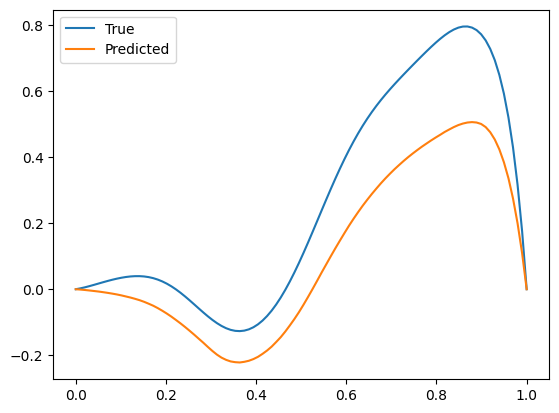

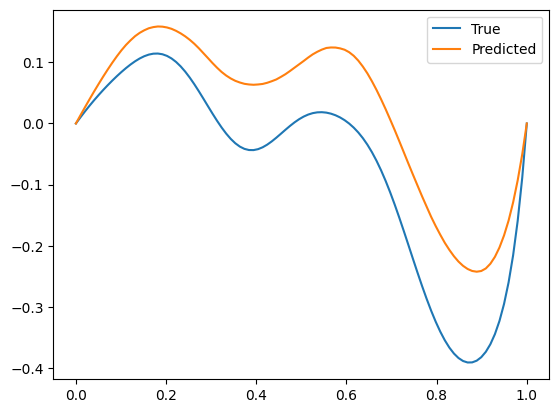

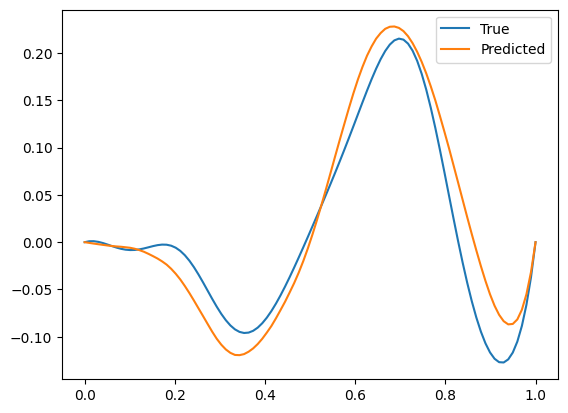

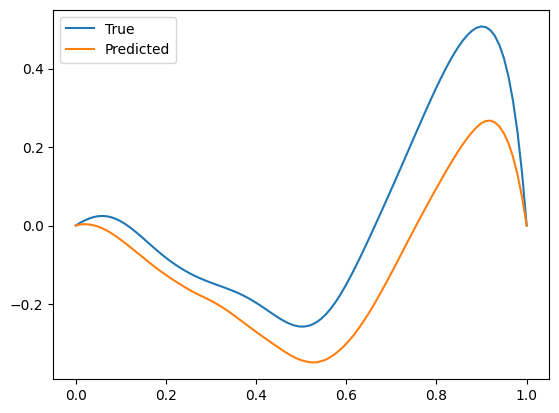

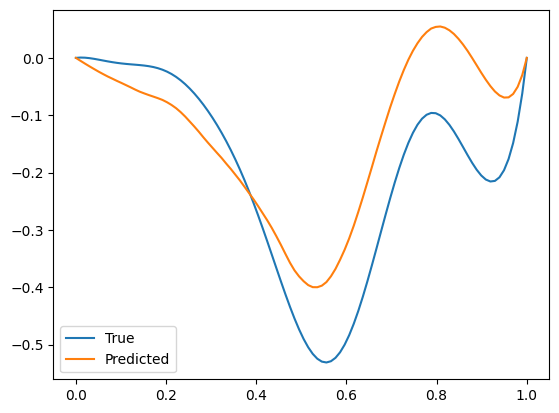

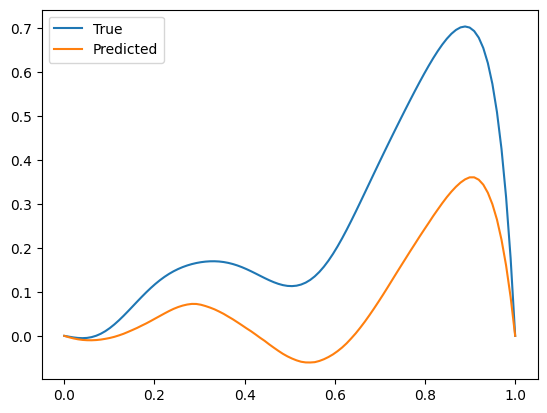

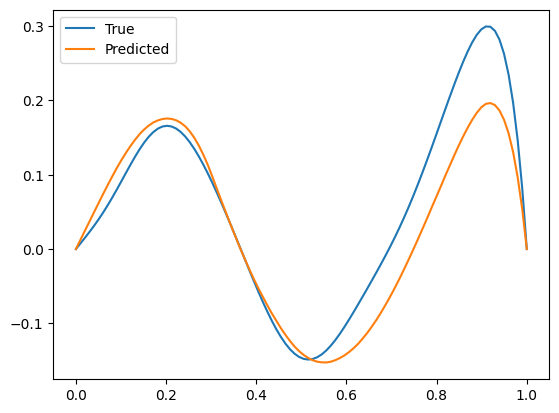

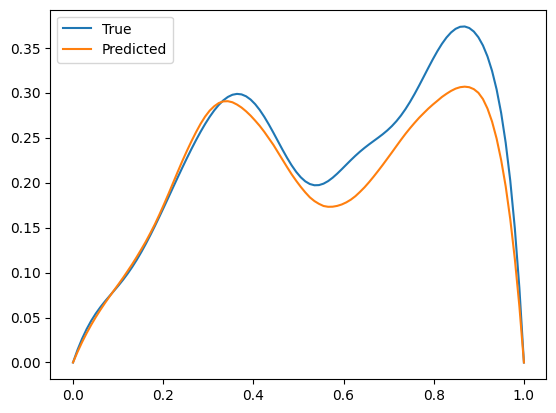

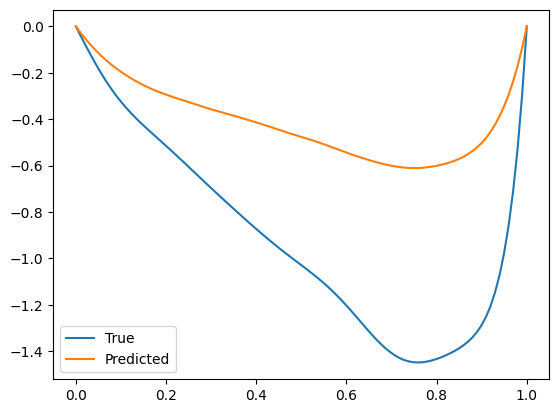

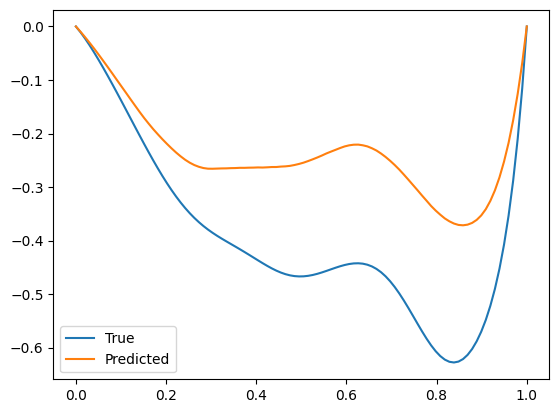

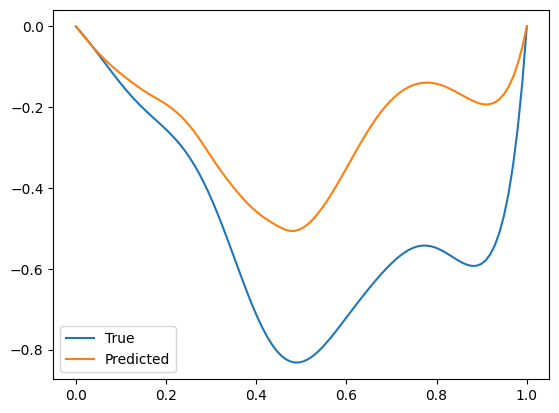

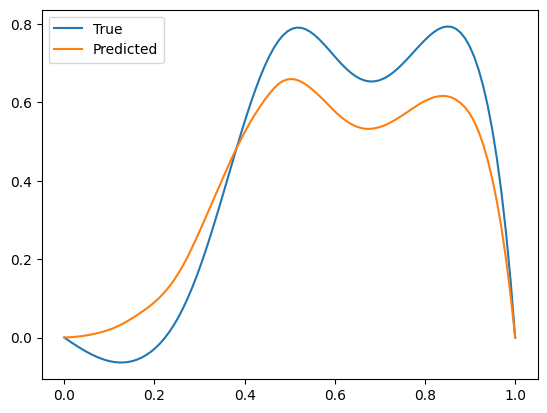

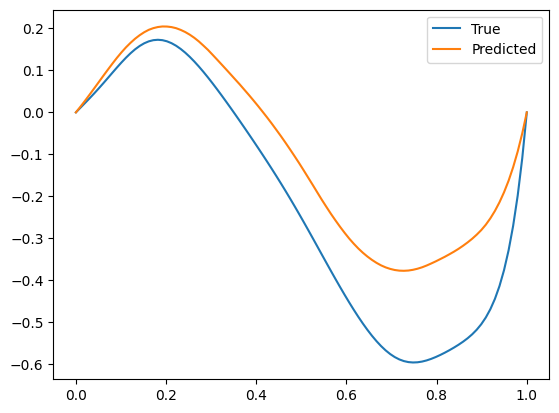

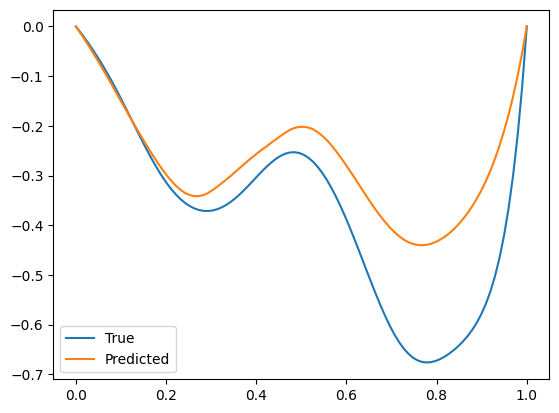

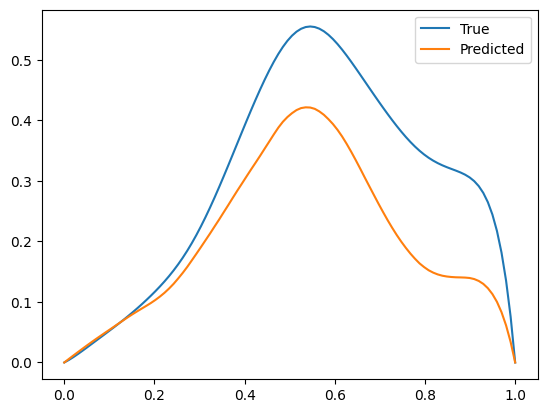

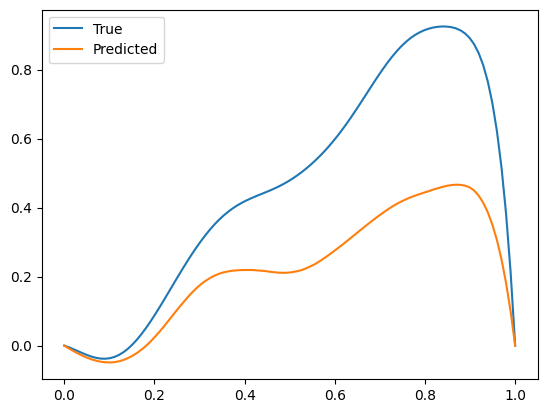

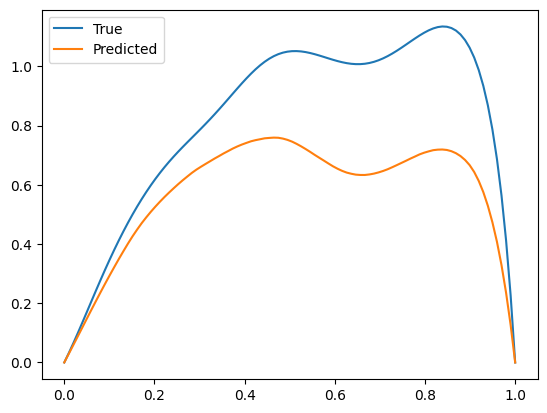

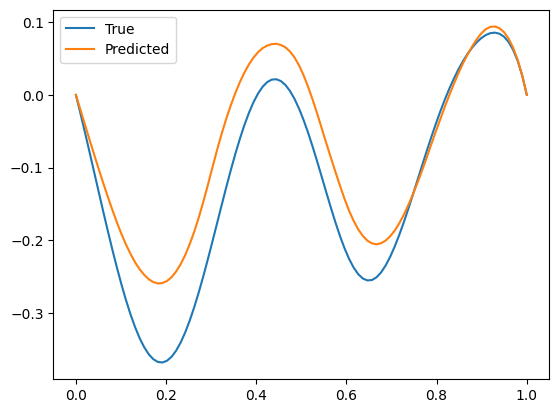

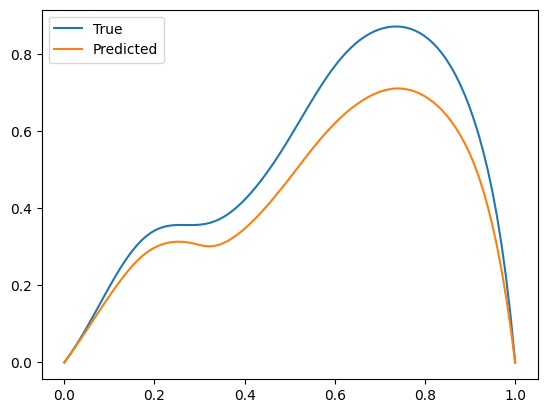

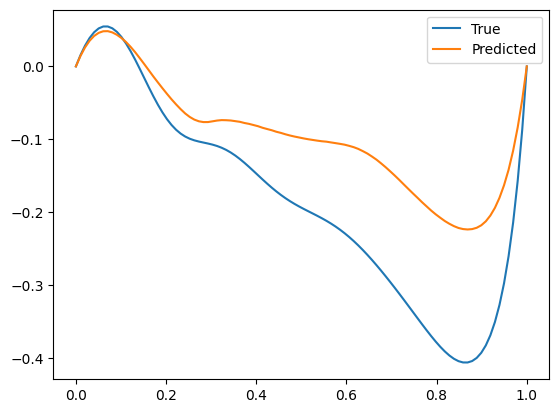

In [ ]:
# then we can test the model
mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

preds = model.predict(mu_test, xs_test)
for i in range(20):
    plt.plot(xs_test[i,:],sol_test[i,:], label='True')
    plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
    plt.legend()
    plt.show()